In [1]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MathsUtilities as MUte
import matplotlib.patheffects as path_effects
import GraphHelpers as GH
%matplotlib inline

### Link to APSIM output Data

In [2]:
con = sqlite3.connect(r'C:\GitHubRepos\ApsimX\Prototypes\Potato\Potato.db')

### Read the Simulations table that has SimulationID matched to Simulation Name

In [3]:
Simulations = pd.read_sql("Select * from _Simulations",
                                con)
Simulations.set_index('ID',inplace=True)

### Read in the Factor table that links factor names and levels to simulation IDs

In [4]:
Factors = pd.read_sql("Select * from _Factors",
                        con)
Factors.set_index('SimulationID',inplace=True)

### Read in the Report generated on the Sowing Event

In [5]:
LocList = pd.read_excel(r'C:\Users\cflhxb\Dropbox\APSIMPotato\List of locations.xlsx')
LocList.set_index('metfile',inplace=True)

In [6]:
import re
def extractLocation(lcn):
    lcn = lcn.replace('MET files\\','')
    lcn = re.sub('\d','',lcn)
    lcn = lcn.replace('.met','')
    return lcn
def extractfileName(fn):
    fn = fn.replace('MET files\\','')
    fn = fn.replace('.met','')
    return fn

In [7]:
Obs = pd.read_sql("Select * from Observed",
                        con)
Obs.set_index('SimulationID',inplace=True)

In [8]:
InitialReport = pd.read_sql("Select * from InitialReport",
                        con)
InitialReport.loc[:,'SimulationName'] = [Simulations.loc[InitialReport.loc[x,'SimulationID'],'Name'] for x in InitialReport.index]
InitialReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
InitialReport.set_index('SimulationID',inplace=True)
InitialReport.loc[:,'Location'] = [extractLocation(x) for x in InitialReport.loc[:,'Weather.FileName']]
InitialReport.loc[:,'FileName'] = [extractfileName(InitialReport.loc[x,'Weather.FileName']) for x in InitialReport.index]
InitialReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Country Loc'] = [InitialReport.loc[x,'Country'] + ' ' + InitialReport.loc[x,'Loc'] for x in InitialReport.index] 

In [9]:
DailyReport = pd.read_sql("Select * from DailyReport",
                        con)
DailyReport.loc[:,'SimulationName'] = [Simulations.loc[DailyReport.loc[x,'SimulationID'],'Name'] for x in DailyReport.index]
DailyReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
DailyReport.set_index('SimulationID',inplace=True)

In [10]:
DailyPreObs = pd.read_sql("Select * from TimeSeriesData",
                        con)
DailyPreObs.loc[:,'SimulationName'] = [Simulations.loc[DailyPreObs.loc[x,'SimulationID'],'Name'] for x in DailyPreObs.index]
DailyPreObs.set_index('SimulationID',inplace=True)
DailyPreObs.drop_duplicates(inplace=True)

In [11]:
HarvestReport = pd.read_sql("Select * from HarvestReport",
                        con)
HarvestReport.loc[:,'SimulationName'] = [Simulations.loc[HarvestReport.loc[x,'SimulationID'],'Name'] for x in HarvestReport.index]
HarvestReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
HarvestReport.loc[:,'PlantPopn'] = 1/((HarvestReport.loc[:,'RowWidth']/1000)* (HarvestReport.loc[:,'InterRowPlantSpace']/1000))
HarvestReport.loc[:,'StemPopn'] = HarvestReport.loc[:,'StemPerTuber'] *  HarvestReport.loc[:,'PlantPopn']
HarvestReport.loc[:,'Location'] = [extractLocation(x) for x in HarvestReport.loc[:,'Weather.FileName']]
HarvestReport.set_index('SimulationID',inplace=True)
HarvestReport.loc[:,'FileName'] = [extractfileName(HarvestReport.loc[x,'Weather.FileName']) for x in HarvestReport.index]
HarvestReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Country Loc'] = [HarvestReport.loc[x,'Country'] + ' ' + HarvestReport.loc[x,'Loc'] for x in HarvestReport.index] 

In [12]:
HarvestPreObs = pd.read_sql("Select * from FinalYieldData",
                        con)
HarvestPreObs.loc[:,'SimulationName'] = [Simulations.loc[HarvestPreObs.loc[x,'SimulationID'],'Name'] for x in HarvestPreObs.index]
HarvestPreObs.set_index('SimulationID',inplace=True)
HarvestPreObs.drop_duplicates(inplace=True)

### List of simulation names that are in observations data set but are not triggering a sowing event

In [13]:
NotPlanted = []
for x in DailyPreObs.index.get_level_values(0).drop_duplicates():
    if x not in InitialReport.index:
        NotPlanted.append(Simulations.loc[x,'Name'])
NotPlanted

[]

## List of Simulation names that are being planted but are not triggering a harvest event

In [14]:
NotHarvested = []
for x in InitialReport.index:
    if x not in HarvestReport.index:
        NotHarvested.append(Simulations.loc[x,'Name'])
NotHarvested

['CHUK9801OTC_NF_NF_99',
 'CHUK9801OTC_NFplus_NF_99',
 'CHUK9801OTC_NFplusplus_NF_99',
 'CHUK9801AA_99',
 'CHFI9801_375',
 'CHFI9801_AA']

In [15]:
Experiments = HarvestReport.Experiment.drop_duplicates().values
Experiments

array(['ABlock', 'Baxters', 'FUE', 'FSP', 'FUE_NI', 'LincolnRS2018',
       'PYM98', 'PYM99', 'Lynetts', 'rainshelter', 'Parilla',
       'Penola_0607', 'Glenroy_0607', None, 'SCRI_84', 'SCRI_86',
       'CPLM8501INVIERNO', 'CPLM8501VERANO', 'CPSR9302', 'CHUK98',
       'CHFI9901', 'AUCB7001', 'CHBE9801', 'CHBE9901', 'CHGR98',
       'CHGR980', 'CHIE980', 'CHIE98', 'CHIT98', 'CHIT980', 'CHSE98',
       'CPLI9201', 'DIJY8401Tylva_84', 'DIJY8401Tylva_85',
       'DIJY8401Tylva_86', 'DIJY9001Kap_90', 'DIJY9001Kap_91',
       'DIJY9001Kap_92', 'DIJY9001Kap_93', 'DITY8101_81', 'DITY8101_82',
       'DITY8101_83', 'IAHM9801', 'IAWM9901', 'INBA9101', 'IPSG8501',
       'OSBO8801NASA_PIX', 'PRBE9701', 'PRKO9701', 'PRPA9701', 'PRPT9801',
       'PRPT9802', 'PRTO9301', 'PULU0801_2008', 'PULU0801_2010',
       'SCDU8401_1984', 'SCDU8401_1985', 'SFUF1001_2011', 'SFUF1001_2012',
       'UFHA1001_F1', 'UFHA1001_F2', 'UFHA1001_F3', 'UFSF01', 'UFSF010',
       'SRF', 'SFF_02_03SituationHewson', 'SFF_0

In [16]:
Folders = ['New Zealand', 'Australia', 'SubStor','Scotland']

In [17]:
Locations = HarvestReport.loc[:,'Loc'].drop_duplicates().values
Locations.sort()
Countries = HarvestReport.loc[:,'Country'].drop_duplicates().values
Countries.sort()
CountryLocs = HarvestReport.loc[:,'Country Loc'].drop_duplicates().values
CountryLocs.sort()

In [18]:
Locations

array(['Balcarce', 'Barrington', 'Belen', 'Benton', 'Branxholm',
       'Canberra', 'Carlow', 'Chertsy', 'Chinoli', 'Coonawarra', 'Cressy',
       'Deloraine', 'Dundee', 'Epping', 'Forthside', 'Giessen',
       'Gothenburg', 'Gunnsplains', 'Hastings', 'Hermiston', 'Huhhot',
       'Jining', 'Jokionen', 'Jyndevad', 'Kalangadoo', 'Kalengyere',
       'Koari', 'La Molina', 'Lameroo', 'Latrobe', 'Lincoln', 'Ludhiana',
       'Modipuran', 'Patacamaya', 'Pukehohe', 'Rapolano', 'San Gabriel',
       'San Ramon', 'Sassafras', 'Sheffield', 'Sutton Bonington',
       'Suwanee', 'Temuka', 'Tervuren', 'Toralapa', 'Tylstrup',
       'Ulverstone', 'Westbury', 'Wynyard', 'Zhalan'], dtype=object)

In [19]:
Countries

array(['Argentina', 'Australia', 'Belgium', 'Bolivia', 'China', 'Denmark',
       'Ecuador', 'England', 'Finland', 'Germany', 'India', 'Ireland',
       'Italy', 'New Zealand', 'Peru', 'Scotland', 'Sweden', 'Uganda',
       'United States'], dtype=object)

In [20]:
CountryLocs

array(['Argentina Balcarce', 'Australia Barrington',
       'Australia Branxholm', 'Australia Canberra',
       'Australia Coonawarra', 'Australia Cressy', 'Australia Deloraine',
       'Australia Epping', 'Australia Forthside', 'Australia Gunnsplains',
       'Australia Kalangadoo', 'Australia Lameroo', 'Australia Latrobe',
       'Australia Sassafras', 'Australia Sheffield',
       'Australia Ulverstone', 'Australia Westbury', 'Australia Wynyard',
       'Belgium Tervuren', 'Bolivia Belen', 'Bolivia Chinoli',
       'Bolivia Koari', 'Bolivia Patacamaya', 'Bolivia Toralapa',
       'China Huhhot', 'China Jining', 'China Zhalan', 'Denmark Jyndevad',
       'Denmark Tylstrup', 'Ecuador San Gabriel',
       'England Sutton Bonington', 'Finland Jokionen', 'Germany Giessen',
       'India Ludhiana', 'India Modipuran', 'Ireland Carlow',
       'Italy Rapolano', 'New Zealand Chertsy', 'New Zealand Hastings',
       'New Zealand Lincoln', 'New Zealand Pukehohe',
       'New Zealand Temuka', '

In [21]:
AllColors = ['black',
 'grey',
 'lightgrey',
 'maroon',
 'indianred',
 'red',
'salmon',
 'darksalmon',
 'lightsalmon',
 'saddlebrown',
 'peru',
 'darkorange',
 'navajowhite',
             'wheat',
 'goldenrod',
 'gold',
 'darkkhaki',
 'olive',
 'yellow',
 'yellowgreen',
 'darkolivegreen',
 'darkseagreen',
 'limegreen',
 'lime',
 'springgreen',
 'mediumspringgreen',
 'lightseagreen',
 'darkslategray',
 'darkcyan',
             'deepskyblue',
 'dodgerblue',
 'slategray',
 'lightsteelblue',
 'royalblue',
 'navy',
 'darkslateblue',
 'mediumpurple',
 'rebeccapurple',
 'darkorchid',
 'violet',
 'purple',
             'mediumvioletred',
 'crimson',
 'pink']
AllColors.sort()

In [22]:
AllColors

['black',
 'crimson',
 'darkcyan',
 'darkkhaki',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'deepskyblue',
 'dodgerblue',
 'gold',
 'goldenrod',
 'grey',
 'indianred',
 'lightgrey',
 'lightsalmon',
 'lightseagreen',
 'lightsteelblue',
 'lime',
 'limegreen',
 'maroon',
 'mediumpurple',
 'mediumspringgreen',
 'mediumvioletred',
 'navajowhite',
 'navy',
 'olive',
 'peru',
 'pink',
 'purple',
 'rebeccapurple',
 'red',
 'royalblue',
 'saddlebrown',
 'salmon',
 'slategray',
 'springgreen',
 'violet',
 'wheat',
 'yellow',
 'yellowgreen']

In [23]:
Cultivars = HarvestReport.Cultivar.drop_duplicates().values
Cultivars.sort()
Cultivars

array(['39707716', 'Achirana', 'Alpha', 'Amarilis', 'Asante', 'Atlantic',
       'Bintje', 'Coliban', 'DTO33', 'Desiree', 'Dianella', 'Fianna',
       'Gabriela', 'Horizon', 'Ib0005', 'IlamHardy', 'JerseyBenny',
       'Jinguan', 'Kaptah', 'Karaka', 'Kexin', 'Kufri Bahar', 'LT1',
       'Luky', 'Maria', 'Maris Piper', 'Moonlight', 'Nadine', 'Neishu',
       'Nooksac', 'Posmo', 'REVOLUCION', 'Red Lasoda', 'RedRascal', 'Rua',
       'RussetBurbank', 'RussetRanger', 'Sava', 'Sebago', 'Spunta',
       'Tylva', 'Waycha', 'Zibaihua'], dtype=object)

In [24]:
CultivarAcronums = ['39','Ac','Al','Am','As','At','Bi','Co','Dt','De','Di','Fi','Ga','Ho','Ib','Ih','Jb',
'Ji','Ka','Kr','Ke','Kb','Lt','Lu','Ma','Mp','Ml','Na','Ne','No','Po','Rv','Rl','Re','Ru',
 'Rb','Rr','Sa','Se','Sp','Ty','Wa','Zi']

In [27]:
CountryProps = pd.DataFrame(index = Countries,columns=['Color'])
pos = 0
for x in CountryProps.index:
    CountryProps.loc[x,'Color'] = AllColors[pos]
    pos += 2
CultivarProps = pd.DataFrame(index = Cultivars, data=CultivarAcronums, columns = ['CultAcro'])
pos=0
for x in CultivarProps.index:
    CultivarProps.loc[x,'Color'] = AllColors[pos]
    pos+=1

ColProps = pd.DataFrame(index=HarvestReport.index)
ColProps.loc[:,'Cultivar'] = CultivarProps.loc[[HarvestReport.loc[x,'Cultivar'] for x in ColProps.index],'Color'].values
ColProps.loc[:,'Country'] = CountryProps.loc[[HarvestReport.loc[x,'Country'] for x in ColProps.index],'Color'].values
ColProps

Cultivar          Country
SimulationID                                  
5                   indianred  mediumvioletred
4                       olive  mediumvioletred
7               lightseagreen  mediumvioletred
3               rebeccapurple  mediumvioletred
6                        grey  mediumvioletred
2                        gold  mediumvioletred
1                   royalblue  mediumvioletred
8                         red  mediumvioletred
11                  royalblue  mediumvioletred
9                   royalblue  mediumvioletred
10                  royalblue  mediumvioletred
14                  royalblue  mediumvioletred
12                  royalblue  mediumvioletred
15                  royalblue  mediumvioletred
13                  royalblue  mediumvioletred
16                  royalblue  mediumvioletred
20                       grey  mediumvioletred
18                       grey  mediumvioletred
21                       grey  mediumvioletred
17                  royalblue  mediumvioletred
19                  royalblue  mediumvioletred
22                       grey  mediumvioletred
23                navajowhite  mediumvioletred
24                navajowhite  mediumvioletred
25                navajowhite  mediumvioletred
26                  royalblue  mediumvioletred
27                  royalblue  mediumvioletred
28            mediumvioletred  mediumvioletred
29            mediumvioletred  mediumvioletred
30              lightseagreen  mediumvioletred
...                       ...              ...
333                 royalblue  mediumvioletred
334                 royalblue  mediumvioletred
336                 royalblue  mediumvioletred
335                 royalblue  mediumvioletred
338                 royalblue  mediumvioletred
337                 royalblue  mediumvioletred
339                 royalblue  mediumvioletred
341                 royalblue  mediumvioletred
340                 royalblue  mediumvioletred
342                 royalblue  mediumvioletred
343                 royalblue  mediumvioletred
345                 royalblue  mediumvioletred
344                 royalblue  mediumvioletred
346                 royalblue  mediumvioletred
347                 royalblue  mediumvioletred
349                 royalblue  mediumvioletred
348                 royalblue  mediumvioletred
352                 royalblue  mediumvioletred
351                 royalblue  mediumvioletred
350                 royalblue  mediumvioletred
353                 royalblue  mediumvioletred
354                 royalblue  mediumvioletred
355                 royalblue  mediumvioletred
357                 royalblue  mediumvioletred
356                 royalblue  mediumvioletred
358                 royalblue  mediumvioletred
359                 royalblue  mediumvioletred
361                 royalblue  mediumvioletred
360                 royalblue  mediumvioletred
362                 royalblue  mediumvioletred

[356 rows x 2 columns]

In [30]:
['AboveGround N', 'AboveGround Wt',
       'TotalLive Wt', 'TotalLive N',
       'AppearedCohortNo', 'CoverGreen',
       'CoverTotal', 'LAI', 'Leaf Live N',
       'Leaf Live Wt', 'Leaf Live NConc',
       'Leaf SpecificArea', 'Stem Live N',
       'Stem Live NConc', 'Stem Live Wt',
       'Tuber DM%',
       'Tuber Live N', 'Tuber Live NConc',
       'Tuber Live Wt', 'Tuber LiveFWt',
       'SW(1)',
       'SW(2)', 'SW(3)',
       'SW(4)', 'SW(5)',
       'SW(6)', 'TotalSWC', 'TotalSoilN', 'TotalNO3',
       'TotalNH4', 'SW(7)']

['$g/m^2$', '$g/m^2$',
       '$g/m^2$', '$g/m^2$',
       '$No$', '$0-1$',
       '$0-1$', '$LAI$', '$g/m^2$',
       '$g/m^2$', '$g/g$',
       'mm2/g', '$g/m^2$',
       '$g/g$', '$g/m^2$',
       '$g/g$',
       '$g/m^2$', '$g/g$',
       '$g/m^2$', '$g/m^2$',
       'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm', '$kg/ha$', '$kg/ha$',
       '$kg/ha$', 'mm/mm']

['$g/m^2$',
 '$g/m^2$',
 '$g/m^2$',
 '$g/m^2$',
 '$No$',
 '$0-1$',
 '$0-1$',
 '$LAI$',
 '$g/m^2$',
 '$g/m^2$',
 '$g/g$',
 'mm2/g',
 '$g/m^2$',
 '$g/g$',
 '$g/m^2$',
 '$g/g$',
 '$g/m^2$',
 '$g/g$',
 '$g/m^2$',
 '$g/m^2$',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm/mm',
 'mm',
 '$kg/ha$',
 '$kg/ha$',
 '$kg/ha$',
 'mm/mm']

In [31]:
AllVars = HarvestPreObs.loc[:,['Observed' in x for x in HarvestPreObs.columns ]].columns.values
for i in range(len(AllVars)):
    AllVars[i] = AllVars[i].replace('Observed.','')
PlotVariables = AllVars[['CheckpointID' not in x and 'Clock' not in x for x in AllVars]]

AllDailyVars = DailyPreObs.loc[:,['Observed' in x for x in DailyPreObs.columns ]].columns.values
for i in range(len(AllDailyVars)):
    AllDailyVars[i] = AllDailyVars[i].replace('Observed.','')
PlotDailyVariables = AllDailyVars[['CheckpointID' not in x and 'Clock' not in x and 'Script' not in x for x in AllDailyVars]]

#Names = ['Tuber Dry Weight','Tuber Fresh Weight', 'Tuber N','DMC','Total Wt', 'Total N']
VariablePars = pd.DataFrame(index=PlotDailyVariables)
VariablePars.loc[:,'Units'] = ['$g/m^2$', '$g/m^2$',
       '$g/m^2$', '$g/m^2$',
       '$No$', '$0-1$',
       '$0-1$', '$LAI$', '$g/m^2$',
       '$g/m^2$', '$g/g$',
       'mm2/g', '$g/m^2$',
       '$g/g$', '$g/m^2$',
       '$g/g$',
       '$g/m^2$', '$g/g$',
       '$g/m^2$', '$g/m^2$',
       'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm/mm',
       'mm/mm', 'mm', '$kg/ha$', '$kg/ha$',
       '$kg/ha$', 'mm/mm']
VariablePars.loc[:,'Names'] = ['AboveGround N', 'AboveGround Wt',
       'TotalLive Wt', 'TotalLive N',
       'AppearedCohortNo', 'CoverGreen',
       'CoverTotal', 'LAI', 'Leaf Live N',
       'Leaf Live Wt', 'Leaf Live NConc',
       'Leaf SpecificArea', 'Stem Live N',
       'Stem Live NConc', 'Stem Live Wt',
       'Tuber DM%',
       'Tuber Live N', 'Tuber Live NConc',
       'Tuber Live Wt', 'Tuber LiveFWt',
       'SW(1)',
       'SW(2)', 'SW(3)',
       'SW(4)', 'SW(5)',
       'SW(6)', 'TotalSWC', 'TotalSoilN', 'TotalNO3',
       'TotalNH4', 'SW(7)']
VariablePars

Units              Names
Potato.AboveGround.N                           $g/m^2$      AboveGround N
Potato.AboveGround.Wt                          $g/m^2$     AboveGround Wt
Potato.TotalLive.Wt                            $g/m^2$       TotalLive Wt
Potato.TotalLive.N                             $g/m^2$        TotalLive N
Potato.Leaf.AppearedCohortNo                      $No$   AppearedCohortNo
Potato.Leaf.CoverGreen                           $0-1$         CoverGreen
Potato.Leaf.CoverTotal                           $0-1$         CoverTotal
Potato.Leaf.LAI                                  $LAI$                LAI
Potato.Leaf.Live.N                             $g/m^2$        Leaf Live N
Potato.Leaf.Live.Wt                            $g/m^2$       Leaf Live Wt
Potato.Leaf.Live.NConc                           $g/g$    Leaf Live NConc
Potato.Leaf.SpecificArea                         mm2/g  Leaf SpecificArea
Potato.Stem.Live.N                             $g/m^2$        Stem Live N
Potato.Stem.Live.NConc                           $g/g$    Stem Live NConc
Potato.Stem.Live.Wt                            $g/m^2$       Stem Live Wt
Potato.Tuber.LiveFWt.DryMatterContent.Value()    $g/g$          Tuber DM%
Potato.Tuber.Live.N                            $g/m^2$       Tuber Live N
Potato.Tuber.Live.NConc                          $g/g$   Tuber Live NConc
Potato.Tuber.Live.Wt                           $g/m^2$      Tuber Live Wt
Potato.Tuber.LiveFWt                           $g/m^2$      Tuber LiveFWt
Soil.SoilWater.SW(1)                             mm/mm              SW(1)
Soil.SoilWater.SW(2)                             mm/mm              SW(2)
Soil.SoilWater.SW(3)                             mm/mm              SW(3)
Soil.SoilWater.SW(4)                             mm/mm              SW(4)
Soil.SoilWater.SW(5)                             mm/mm              SW(5)
Soil.SoilWater.SW(6)                             mm/mm              SW(6)
TotalSWC                                            mm           TotalSWC
TotalSoilN                                     $kg/ha$         TotalSoilN
TotalNO3                                       $kg/ha$           TotalNO3
TotalNH4                                       $kg/ha$           TotalNH4
Soil.SoilWater.SW(7)                             mm/mm              SW(7)

In [32]:
def SortedPlot(Var,GroupVar,GroupList,ax):
    Sorted = HarvestReport.sort_values(GroupVar)
    Sorted.loc[:,'Linear'] = range(Sorted.index.size)
    tickPos = []
    pastx = -10
    ymin = Sorted.loc[:,Var].min()
    ymax = Sorted.loc[:,Var].max()
    DataRange = ymax-ymin
    Offset = DataRange * 0.01
    for g in GroupList:
        ColDF = globals()[GroupVar+'Props']
        col = ColDF.loc[g,'Color']
        ffilter = Sorted.loc[:,GroupVar] == g
        plt.plot(Sorted.loc[ffilter,'Linear'],Sorted.loc[ffilter,Var],
                 'o',color=col,ms=15)
        xloc = Sorted.loc[ffilter,'Linear'].mean()#.iloc[0],pastx+5)
        pastx = xloc
        yloc = Sorted.loc[ffilter,Var].max() + Offset# + random.randint(-40,40)
        plt.text(xloc-5,yloc,g,fontsize=16,color=col,rotation=0,
                 verticalalignment='bottom',horizontalalignment='center')
    plt.ylabel(Var,fontsize=20)
    plt.ylim(ymin,ymax*1.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=16)
    plt.title(Var,fontsize=30)        

def makeConfigPlots(PlotVars,GroupVar,GroupList):
    no = len(GroupVar)
    rows = np.ceil(no/2) + 1
    pos=1
    for v in Vars:
        ax = Graph.add_subplot(rows,2,pos)
        SortedPlot(v,GroupVar,GroupList,ax)
        pos+=1
    

## The following series of Graphs present a series of variables that reflect the configuration of each simulation so these can be sense checked against the rest of the validation set

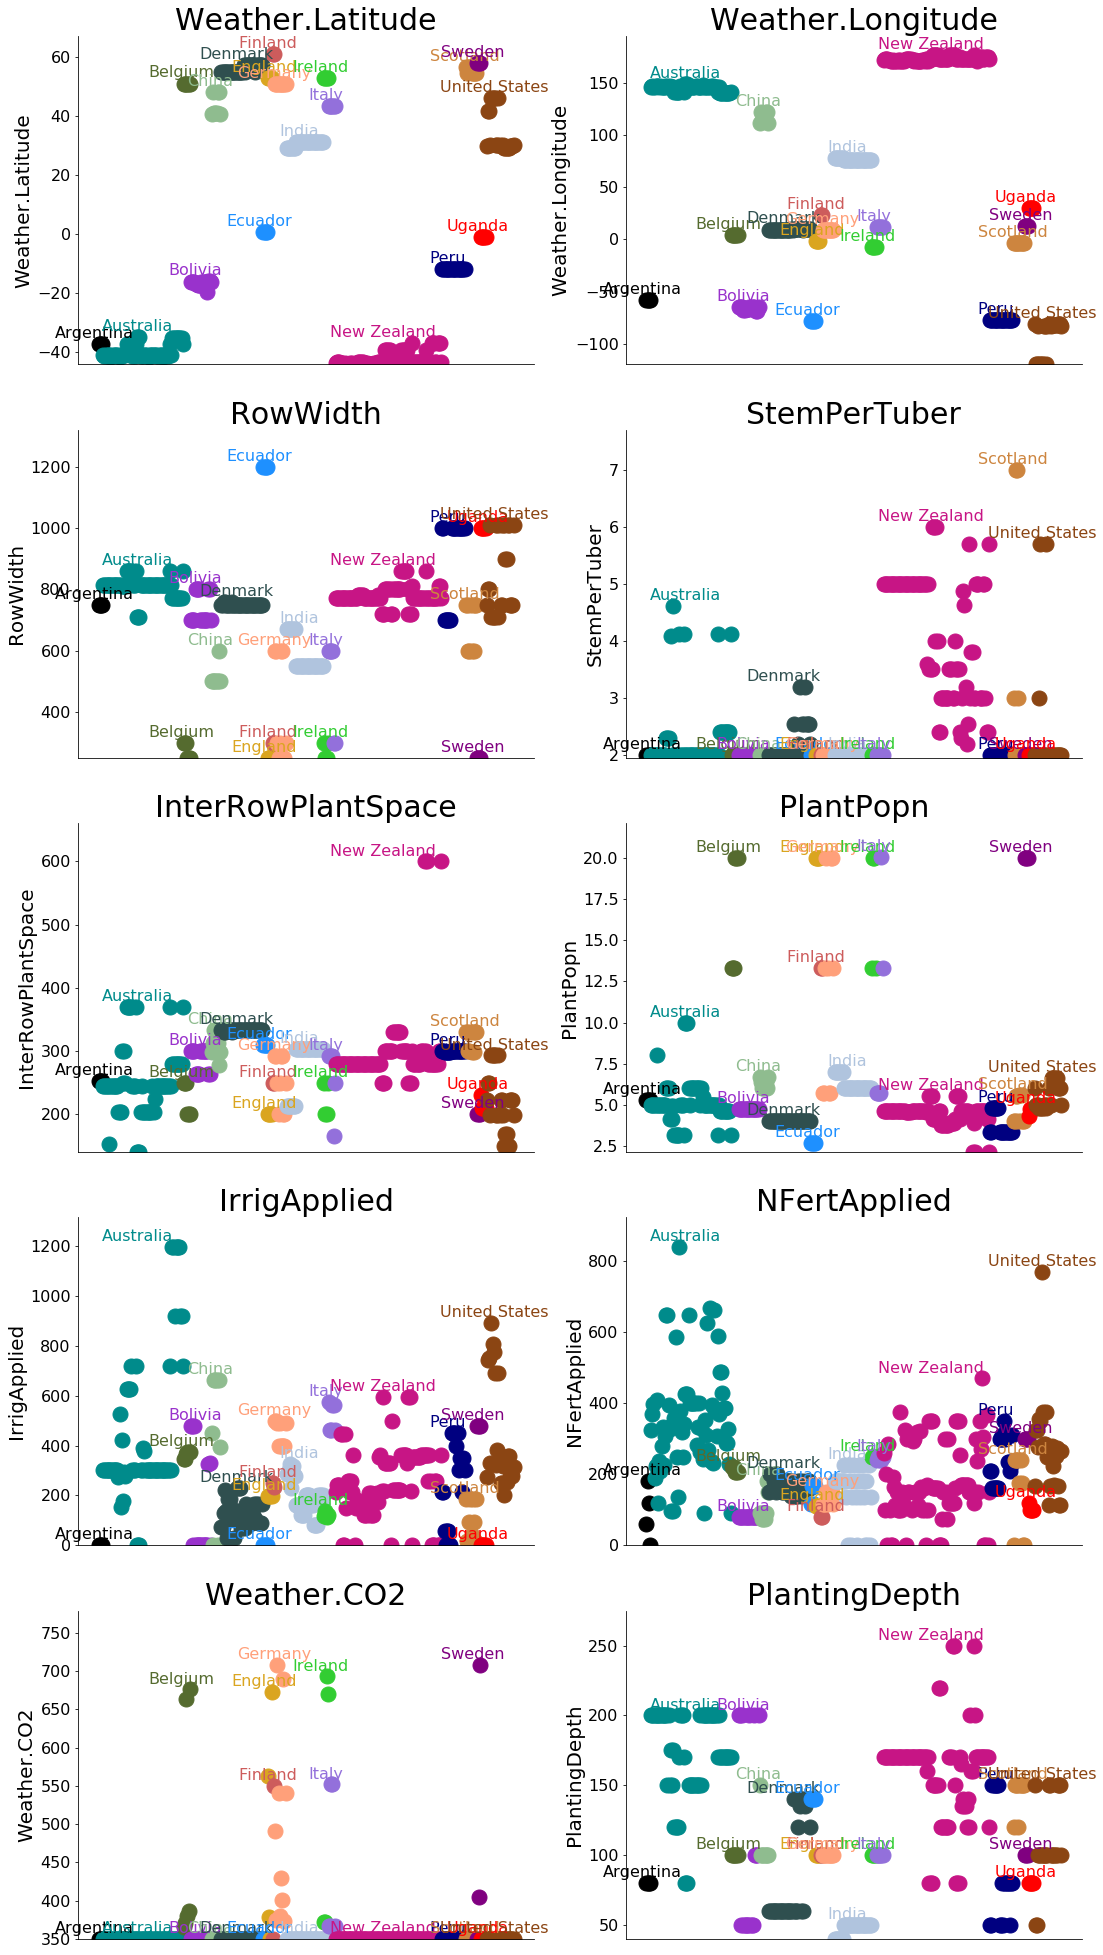

In [34]:
Graph = plt.figure(figsize=(18,35))
Vars = ['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']
makeConfigPlots(Vars,'Country',Countries)

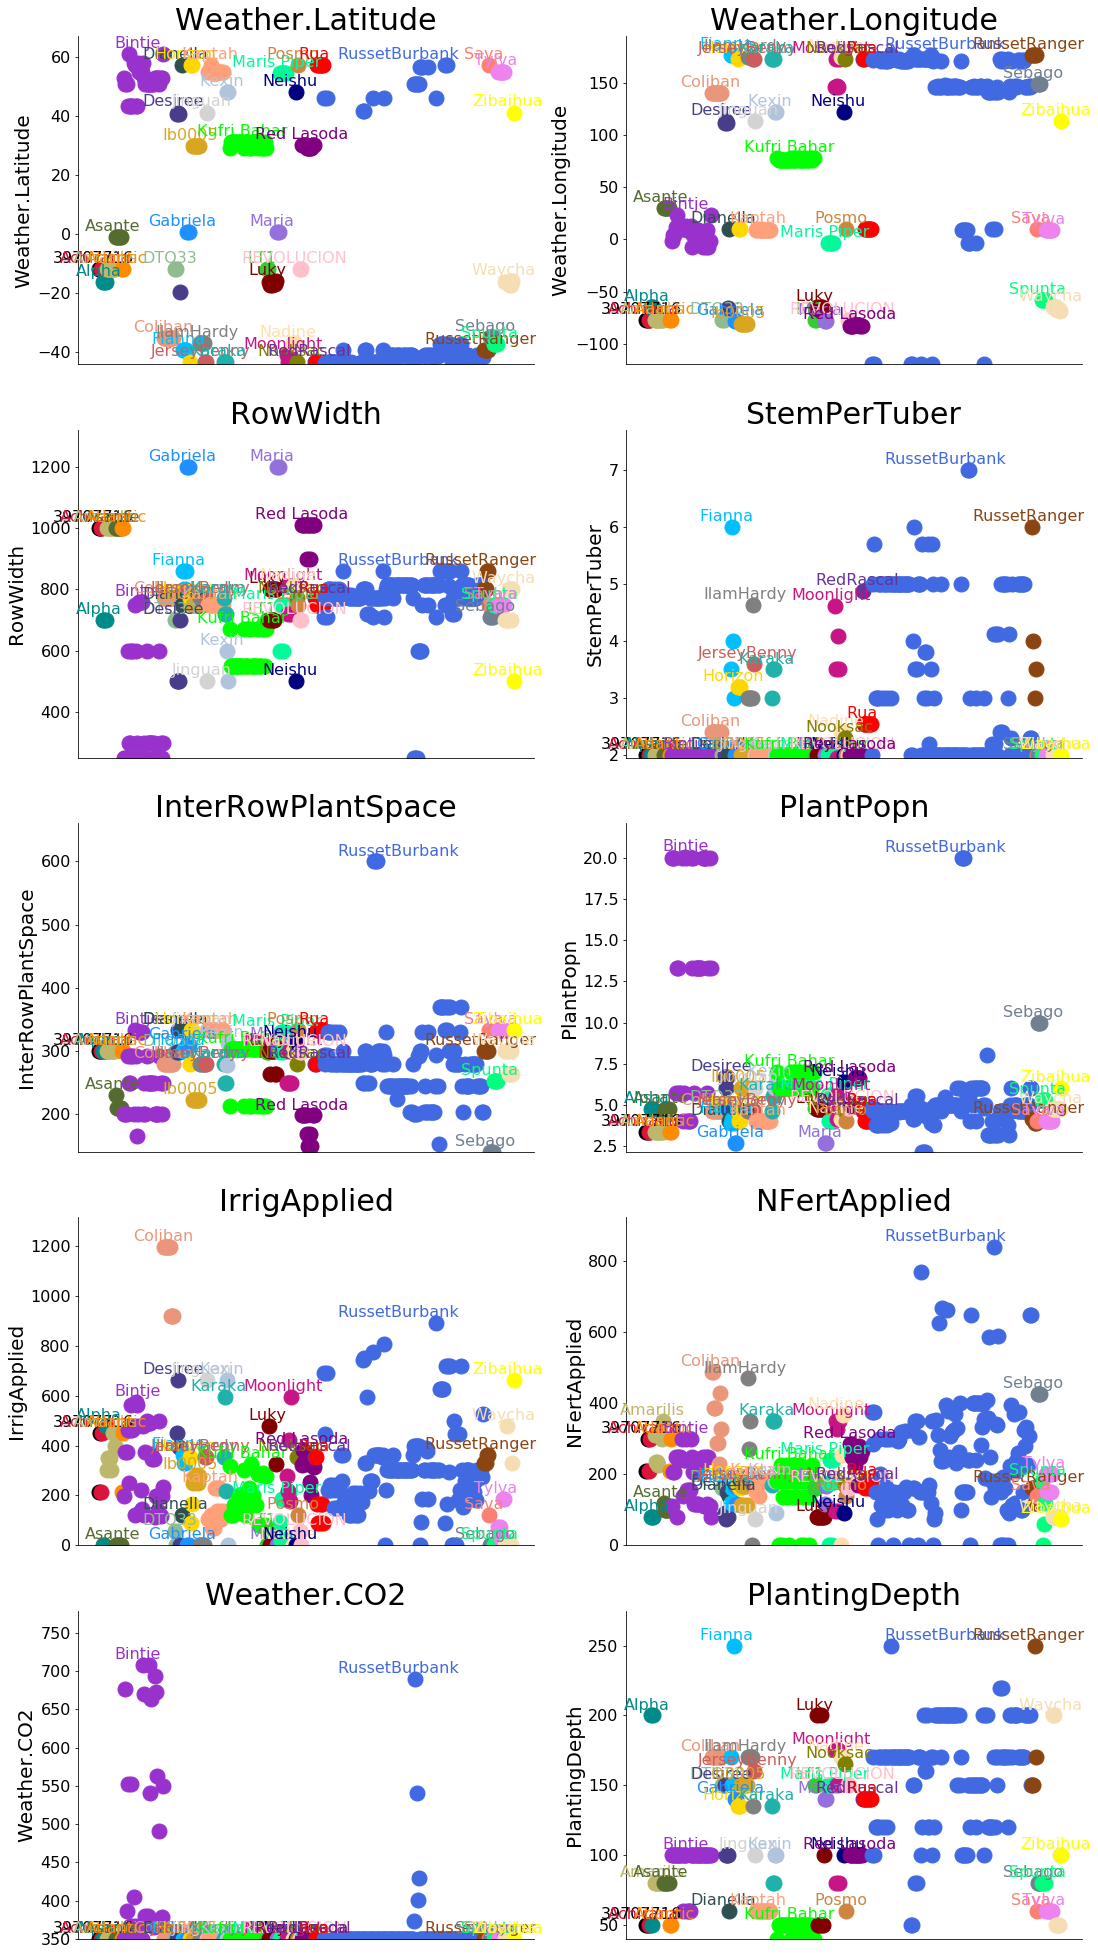

In [35]:
Graph = plt.figure(figsize=(18,35))
Vars = ['Weather.Latitude','Weather.Longitude',
       'RowWidth','StemPerTuber',
       'InterRowPlantSpace','PlantPopn',
       'IrrigApplied','NFertApplied',
       'Weather.CO2', 'PlantingDepth']
makeConfigPlots(Vars,'Cultivar',Cultivars)

In [36]:
def plotDepthVars(VarName,depthNorm):
    Thicks = InitialReport.loc[:,[X for X in InitialReport.columns if 'Thickness' in X]]
    Depths = Thicks.cumsum(axis=1)
    Vars = InitialReport.loc[:,[X for X in InitialReport.columns if VarName in X]]
    LayerDB = pd.DataFrame()
    for x in Depths.index:
        SimLayerDB = pd.DataFrame(index = pd.MultiIndex.from_product([[x],['LayerBounds','Varval']]))
        LayerBounds = [0.0]
        depthNormFact = 1 
        if depthNorm == True:
            depthNormFact = Thicks.loc[x,:][0]
        Varvals = [Vars.loc[x,:][0]/depthNormFact]
        for l in range(13):
            try:
                if depthNorm == True:
                    depthNormFact = Thicks.loc[x,:][l]
                LayerBounds.append(float(Depths.loc[x,:][l])*-1)
                Varvals.append(Vars.loc[x,:][l]/depthNormFact)
            except:
                do = 'Nothing'
        for p in range(len(LayerBounds)):
            SimLayerDB.loc[(x,'LayerBounds'),p] = LayerBounds[p]
            SimLayerDB.loc[(x,'Varval'),p] = Varvals[p]
        LayerDB = pd.concat([LayerDB,SimLayerDB])
        LayerDB.index = LayerDB.index.swaplevel()
        LayerBounds = LayerDB.stack().loc['LayerBounds']
        VarVals = LayerDB.stack().loc['Varval']
        LayerDB = pd.concat([LayerDB,SimLayerDB])
    MaxDep = LayerDB.loc[(slice(None),'LayerBounds'),:].min(axis=1).min()
    MinVar = LayerDB.loc[(slice(None),'Varval'),:].min(axis=1).min()
    MaxVar = LayerDB.loc[(slice(None),'Varval'),:].max(axis=1).max()    
    Graph = plt.figure(figsize=(10,20))
    cols = np.ceil(len(Locations)/5)
    pos=1
    for lcn in Locations:
        ax = Graph.add_subplot(cols,5,pos)
        #for x in Depths.index:
        #    plcn = InitialReport.loc[x,'Location']
        plt.plot(VarVals,LayerBounds,'o',color = 'lightgrey')
        plt.text(0.03,1.0,lcn,transform=ax.transAxes,fontsize=12)
        LocalVars = HarvestReport.loc[HarvestReport.loc[:,'Loc']==lcn,:].index
        for l in LocalVars:
            plt.plot(LayerDB.loc[(l,'Varval'),:],LayerDB.loc[(l,'LayerBounds'),:],'-o',color = 'red')
        plt.ylim(MaxDep*1.05,0)
        plt.xlim(MinVar * 0.8,MaxVar * 1.05)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Depth (cm)',fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Locations)-4,len(Locations)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel(VarName,fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos += 1
    plt.tight_layout

## The flowing series of graphs show CropSoil configuration settings for each simulation so they can be sense checked against the rest of the validation set

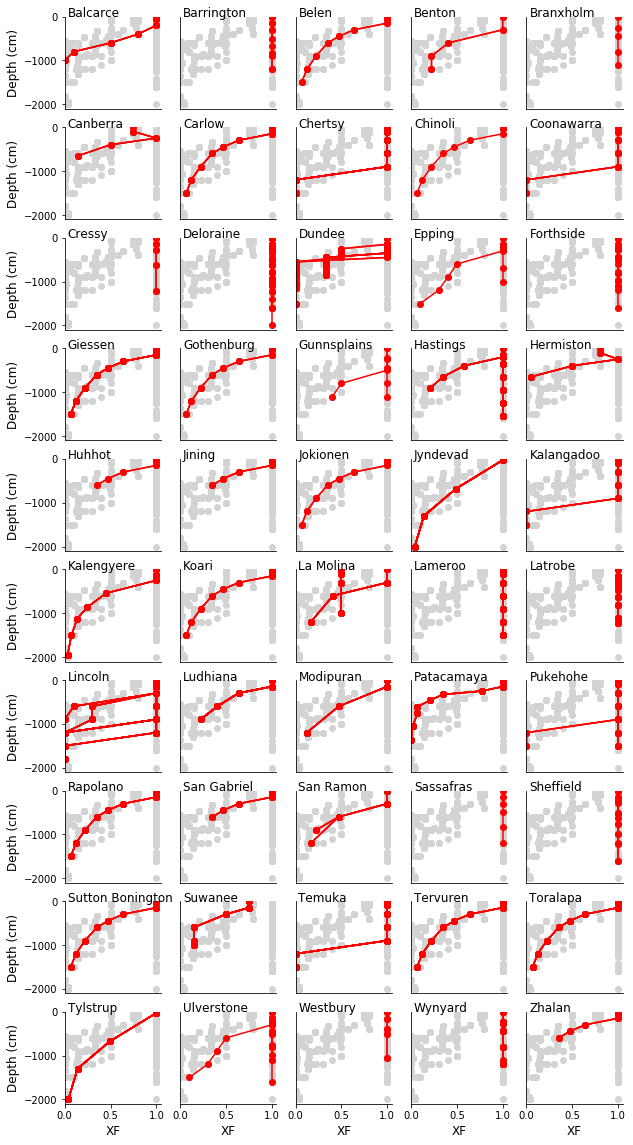

In [37]:
plotDepthVars('XF',False)

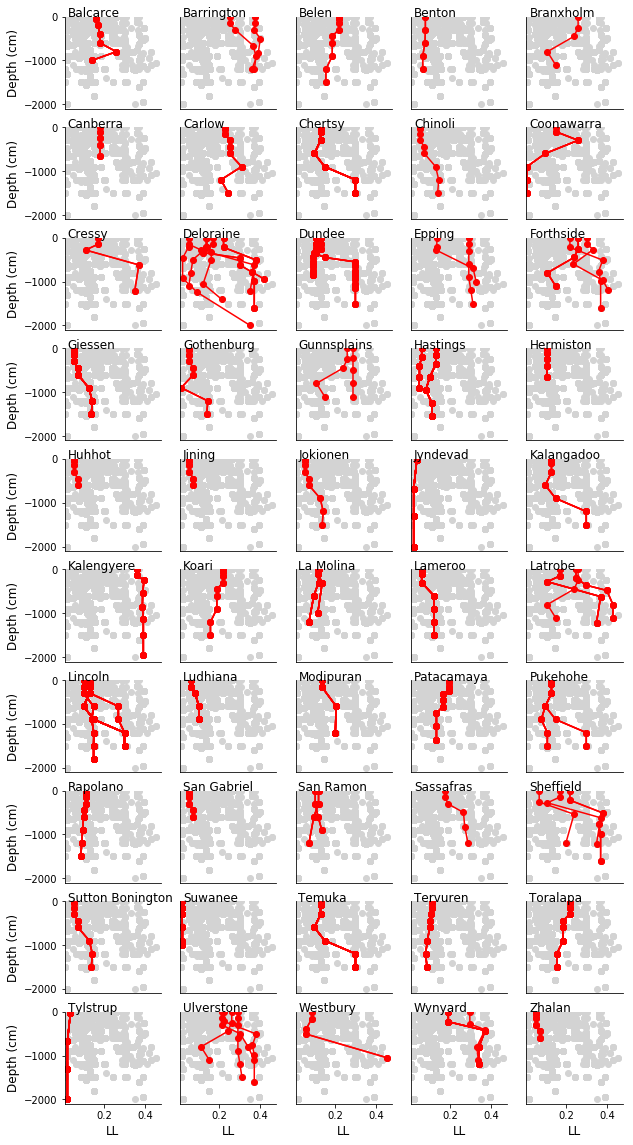

In [38]:
plotDepthVars('LL',False)

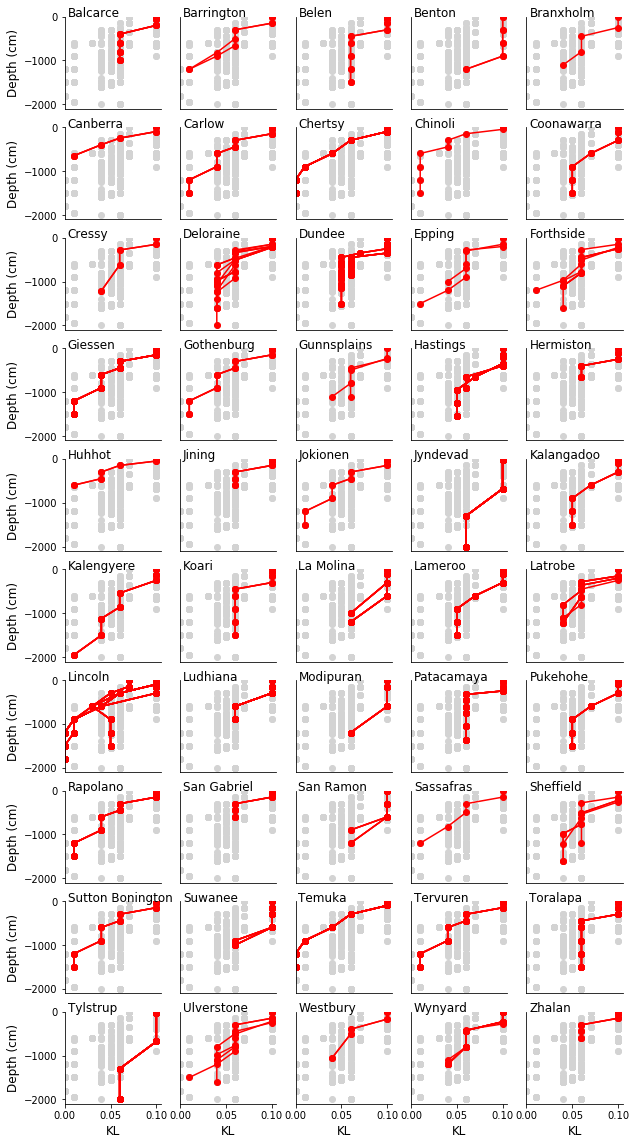

In [39]:
plotDepthVars('KL',False)

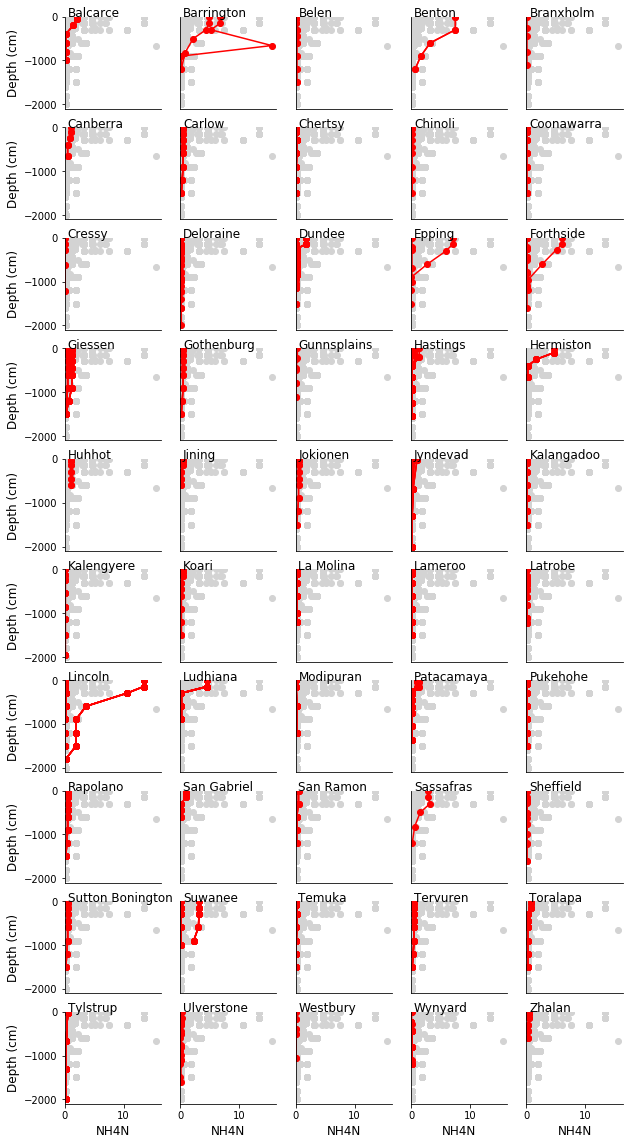

In [40]:
plotDepthVars('NH4N',False)

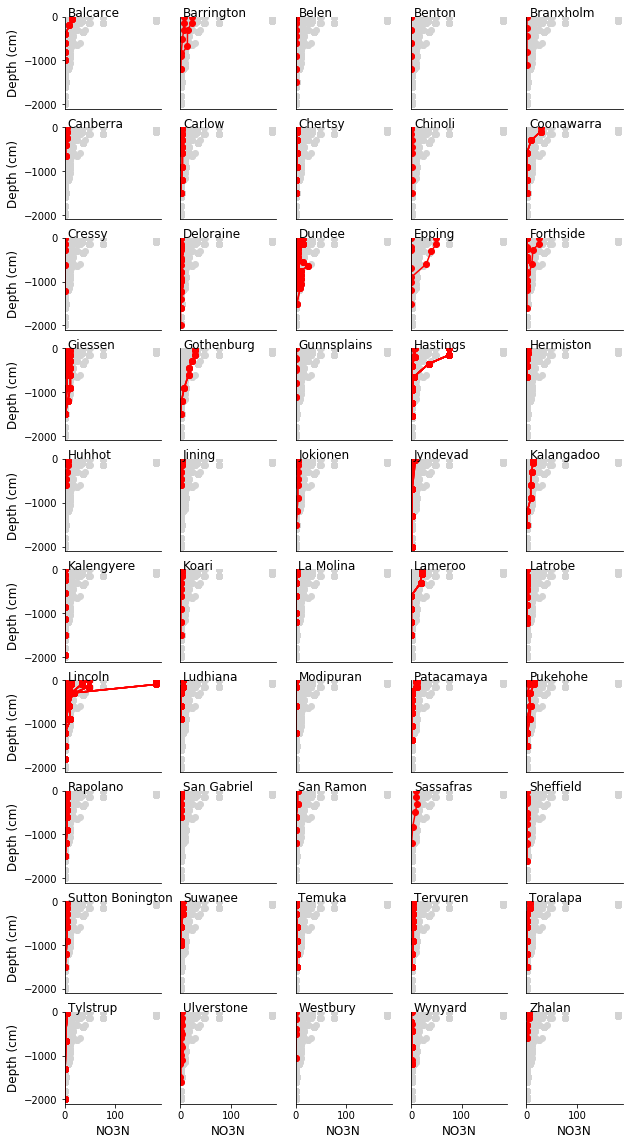

In [41]:
plotDepthVars('NO3N',False)

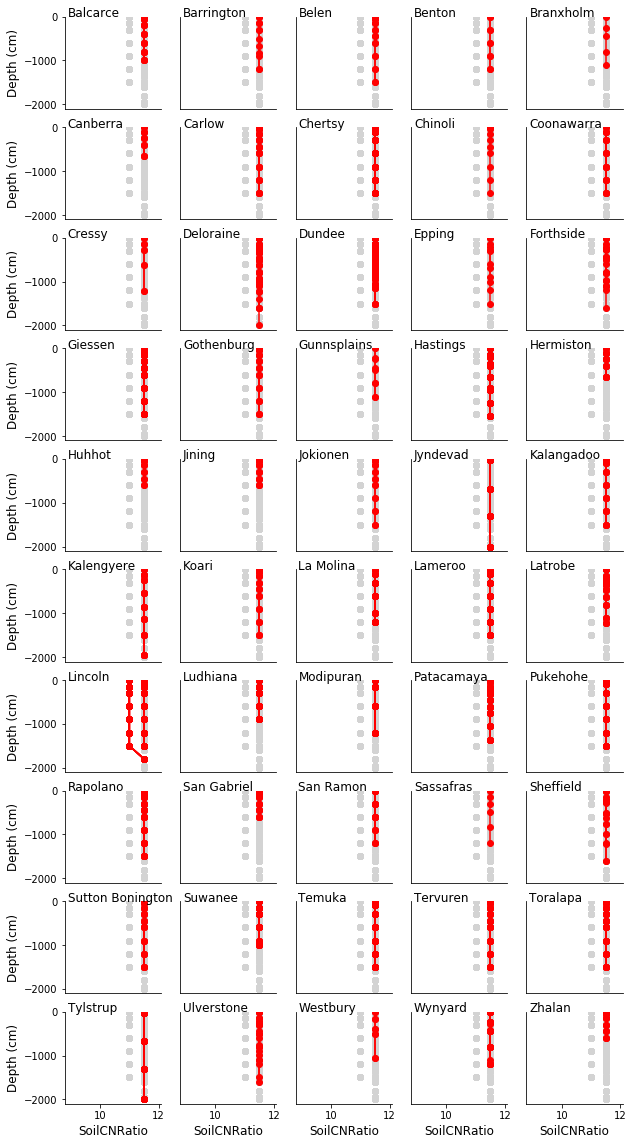

In [42]:
plotDepthVars('SoilCNRatio',False)

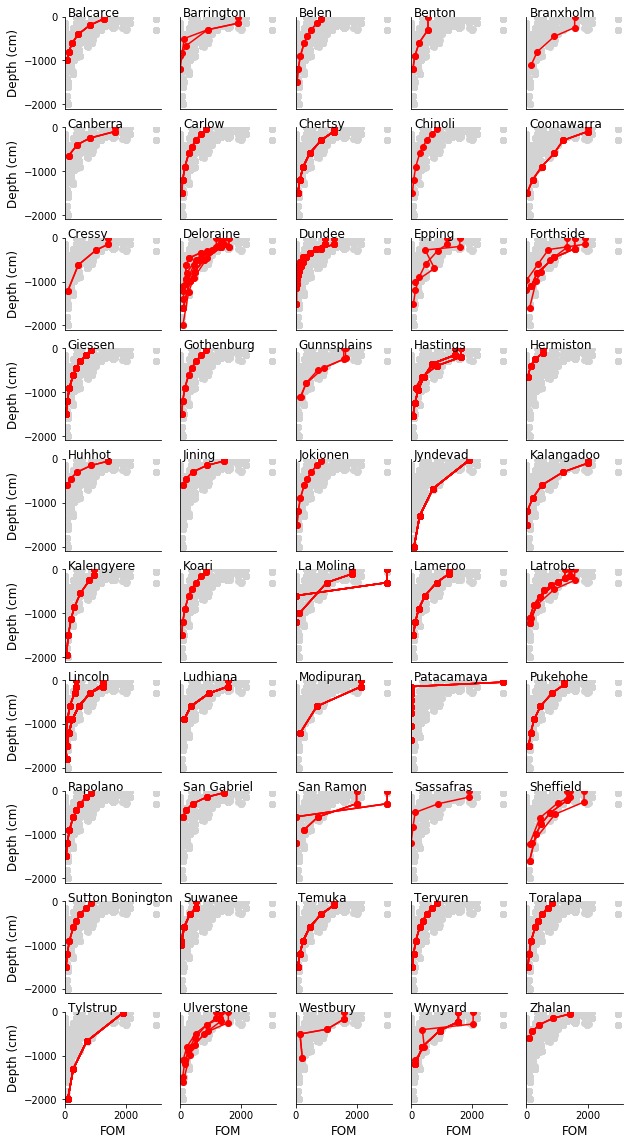

In [43]:
plotDepthVars('FOM',False)

In [44]:
def MakeLabel(RegStats):
    #text = RegStats.Name + '  n = ' + str(RegStats.n)
    text = '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    text += '\n$r^2$ =' + '%.2f'%RegStats.R2 + ' RMSE = ' + '%.2f'%RegStats.RMSE +' NSE = ' + '%.2f'%RegStats.NSE
    text += '\nME = ' + '%.2f'%RegStats.ME + ' MAE = ' + '%.2f'%RegStats.MAE
    text += '\nn = ' + str(RegStats.n)
    return text

def AddObsPredGraph(Variables,DataTable,GroupVar,GroupList):
    Pos = 1
    for Var in Variables:
        NaNFilter = np.isnan(DataTable.loc[:,'Predicted.'+Var]) | np.isnan(DataTable.loc[:,'Observed.'+Var])
        IaNFilter = ~NaNFilter
        Obs = DataTable.loc[:,'Observed.'+Var].loc[IaNFilter].values
        Pred = DataTable.loc[:,'Predicted.'+Var].loc[IaNFilter].values
        no = len(Variables)
        rows = np.ceil(no/3)
        ax = Graph.add_subplot(rows,3,Pos)
        ColPos = 0
        MarPos = 0
        for g in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[g,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar] == g].index.values
            ExpObs = DataTable.loc[SimIDs,'Observed.'+Var]
            ExpPred = DataTable.loc[SimIDs,'Predicted.'+Var]
            plt.plot(ExpObs,ExpPred,'o',color = col,label=g)
            ColPos +=1
            if ColPos == 30:
                ColPos = 1
                MarPos +=1
        uplim = max(Obs.max(),Pred.max())*1.1
        lowlim = min(Obs.min(),Pred.min())*0.95
        plt.text(0.02,0.94,VariablePars.loc[Var,'Names'],transform=ax.transAxes,fontsize=20)
        plt.ylim(0,uplim)
        plt.xlim(0,uplim)
        plt.plot([lowlim,uplim*.95],[lowlim,uplim*.95],'-',color='k')
        RegStats = MUte.MathUtilities.CalcRegressionStats(Var,Pred,Obs)
        LabelText = MakeLabel(RegStats)
        #plt.text(uplim*0.05,uplim*.78,LabelText)
        #Fit linear regression to current series and store slope and intercept in dataframe
        ModFit = sm.regression.linear_model.OLS(Pred,  # Y variable
                                            sm.add_constant(Obs), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
        RegFit = ModFit.fit();  # fit models parameters
        Slope = RegFit.params[1] 
        Intercept = RegFit.params[0]
        Xs = [lowlim,uplim*.95]
        Ys = [Intercept + Xs[0]*Slope,Intercept + Xs[1]*Slope]
        plt.plot(Xs,Ys,'--',color='r')
        plt.ylabel('Pred ' + VariablePars.loc[Var,'Names'] + ' ('  + VariablePars.loc[Var,'Units'] + ')')
        plt.xlabel('Obs ' + VariablePars.loc[Var,'Names'] + ' ('  + VariablePars.loc[Var,'Units'] + ')')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        if Pos == 1:
            GH.AddLegend(LegLoc = (0,1.1),labelsize=16,Title='',NCol=5,MScale=2)
        Pos +=1

## Standard Obs vs Pred graph for Harvest

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


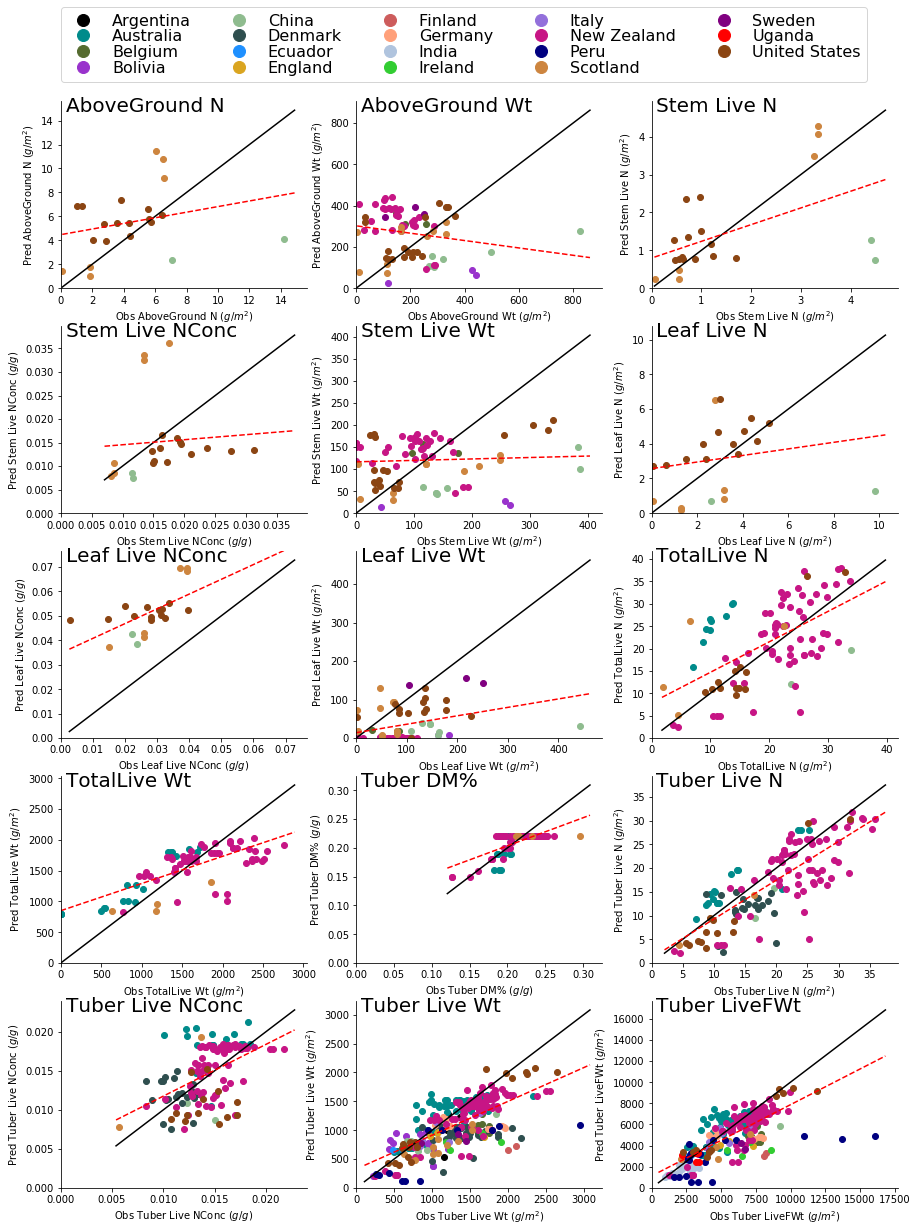

In [45]:
Graph = plt.figure(figsize=(15,20))
AddObsPredGraph(PlotVariables,HarvestPreObs,'Country',Countries)

## Standard Obs vs Pre graph for time series data

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
C:\Anaconda\lib\MathsUtilities.py:766: RuntimeWarning: invalid value encountered in sqrt
  stats.SEslope = np.sqrt(S2) / np.sqrt(CSSX) # Standard errors estimated from S2 & CSSX
C:\Anaconda\lib\MathsUtilities.py:767: RuntimeWarning: invalid value encountered in sqrt
  stats.SEintercept = np.sqrt(S2) * np.sqrt(SumX2 / (Num_points * CSSX))


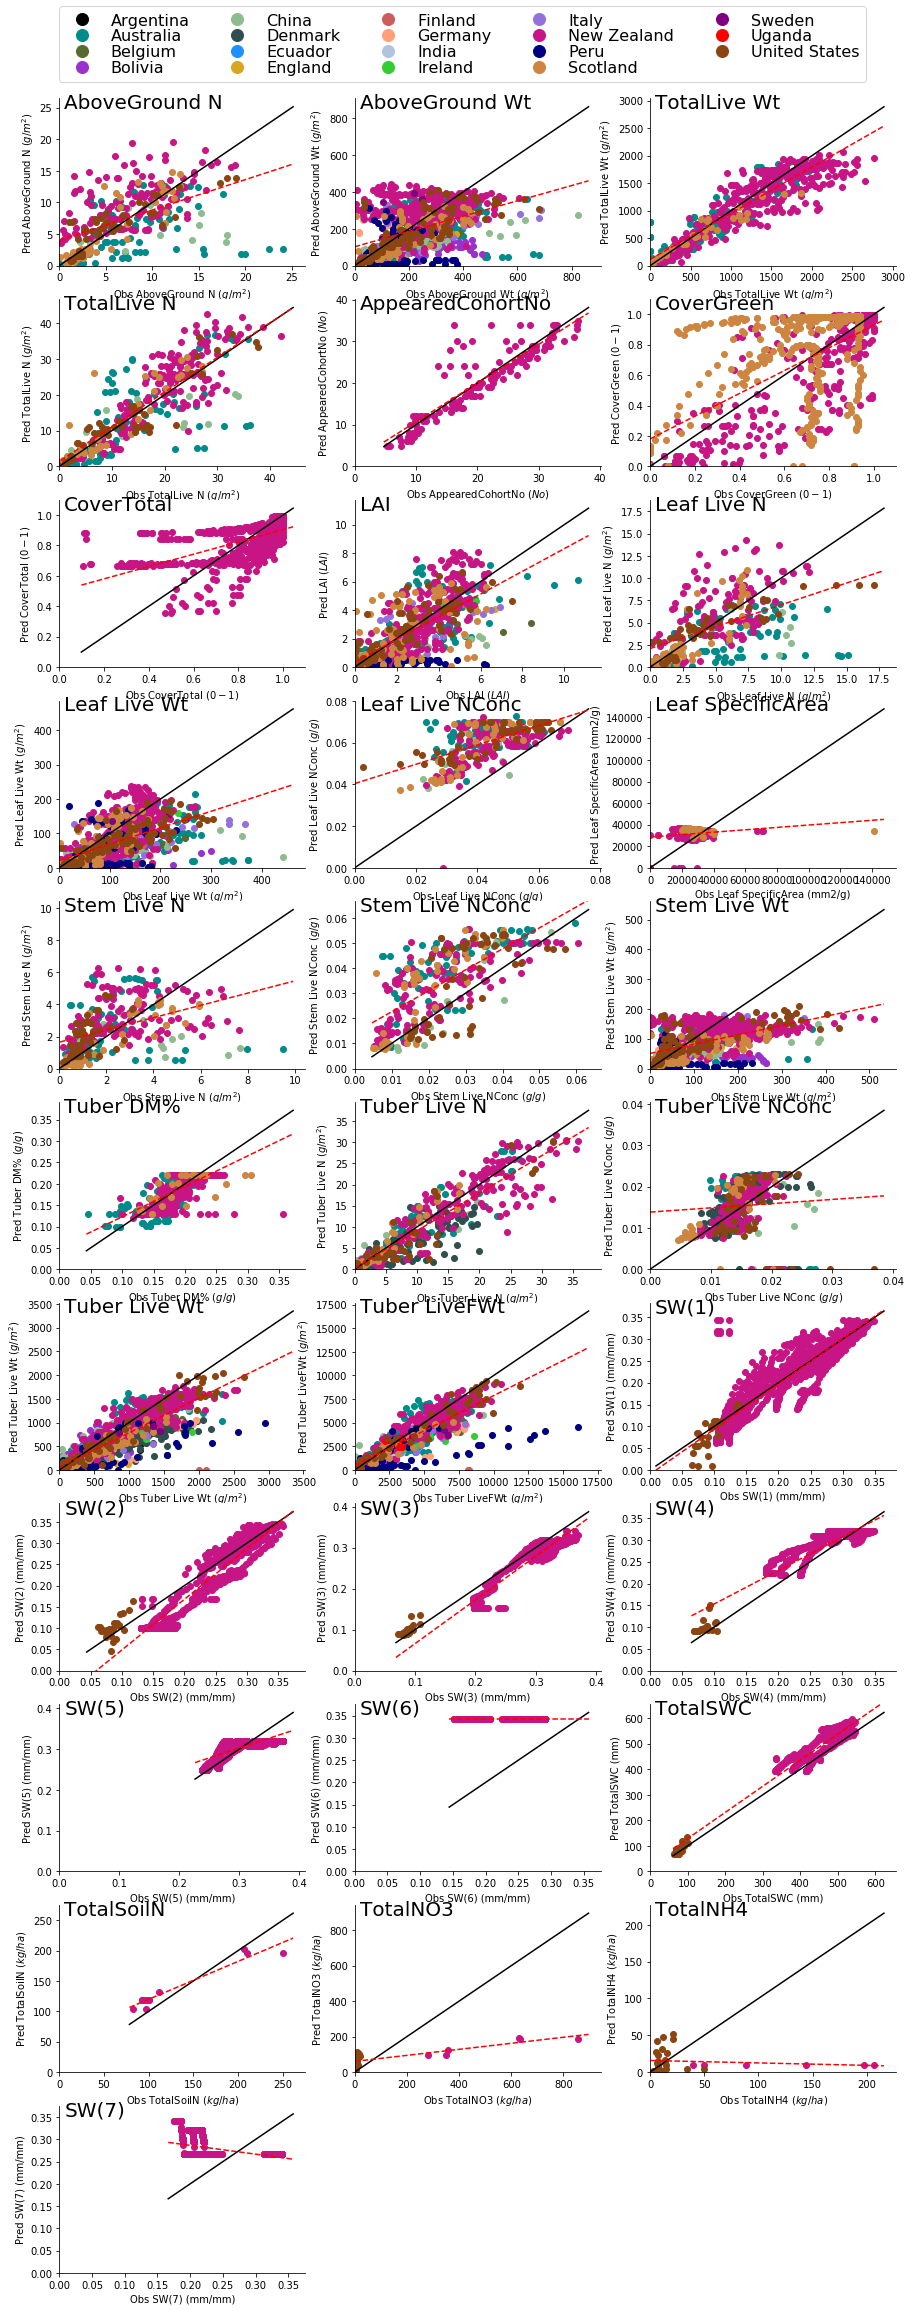

In [46]:
Graph = plt.figure(figsize=(15,40))
AddObsPredGraph(PlotDailyVariables,DailyPreObs,'Country',Countries)

In [47]:
HarvestResiduals = HarvestPreObs.loc[:,[X for X in HarvestPreObs.columns if 'Pred-Obs' in X]].copy()

In [48]:
def GroupResidulesGraph(Variables,ResidulesTable,GroupList,GroupVar):
    panpos = 1
    rows = len(Variables)
    for Var in Variables:
        ax = Graph.add_subplot(rows,1,panpos)
        startx = 0
        tickPoss = []
        tickLabs = []
        colpos = 1
        upper = ResidulesTable.loc[:,'Pred-Obs.' + Var].max() * 1.1
        lower = ResidulesTable.loc[:,'Pred-Obs.' + Var].min() * 1.1
        MeanResidual = ResidulesTable.loc[:,'Pred-Obs.' + Var].mean()
        TextPos = 'Lower'
        for group in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[group,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar]==group,:].index.values
            xvals = range(startx,startx+len(SimIDs))
            plt.plot(xvals,ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.' + Var],
                     '-o',color=col)
            #tickPoss.append(startx+len(SimIDs)/2)
            tickLabs.append(group)
            if TextPos=='Lower':
                plt.text(startx+len(SimIDs)/2,lower,group,fontsize=16,
                         color=col,rotation=-45,verticalalignment='bottom',horizontalalignment='center')
                TextPos = 'Upper'
            else:
                plt.text(startx+len(SimIDs)/2,upper,group,fontsize=16,
                         color=col,rotation=-45,verticalalignment='top',horizontalalignment='center')
                TextPos = 'Lower'
            startx += len(SimIDs)
            if colpos == 30:
                colpos = 0
            colpos+=1
        ax.xaxis.set_major_locator(plt.FixedLocator(tickPoss))
        ax.set_xticklabels(tickLabs)
        plt.tick_params(rotation=90)
        plt.plot([0,startx],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,startx],[0,0],'--',lw=3,color='k')
        plt.ylim(lower,upper)
        plt.title(Var,fontsize=25)
        plt.ylabel('Pred-Obs')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        panpos+=1

## Graph residuals for key variables grouped by cultivar

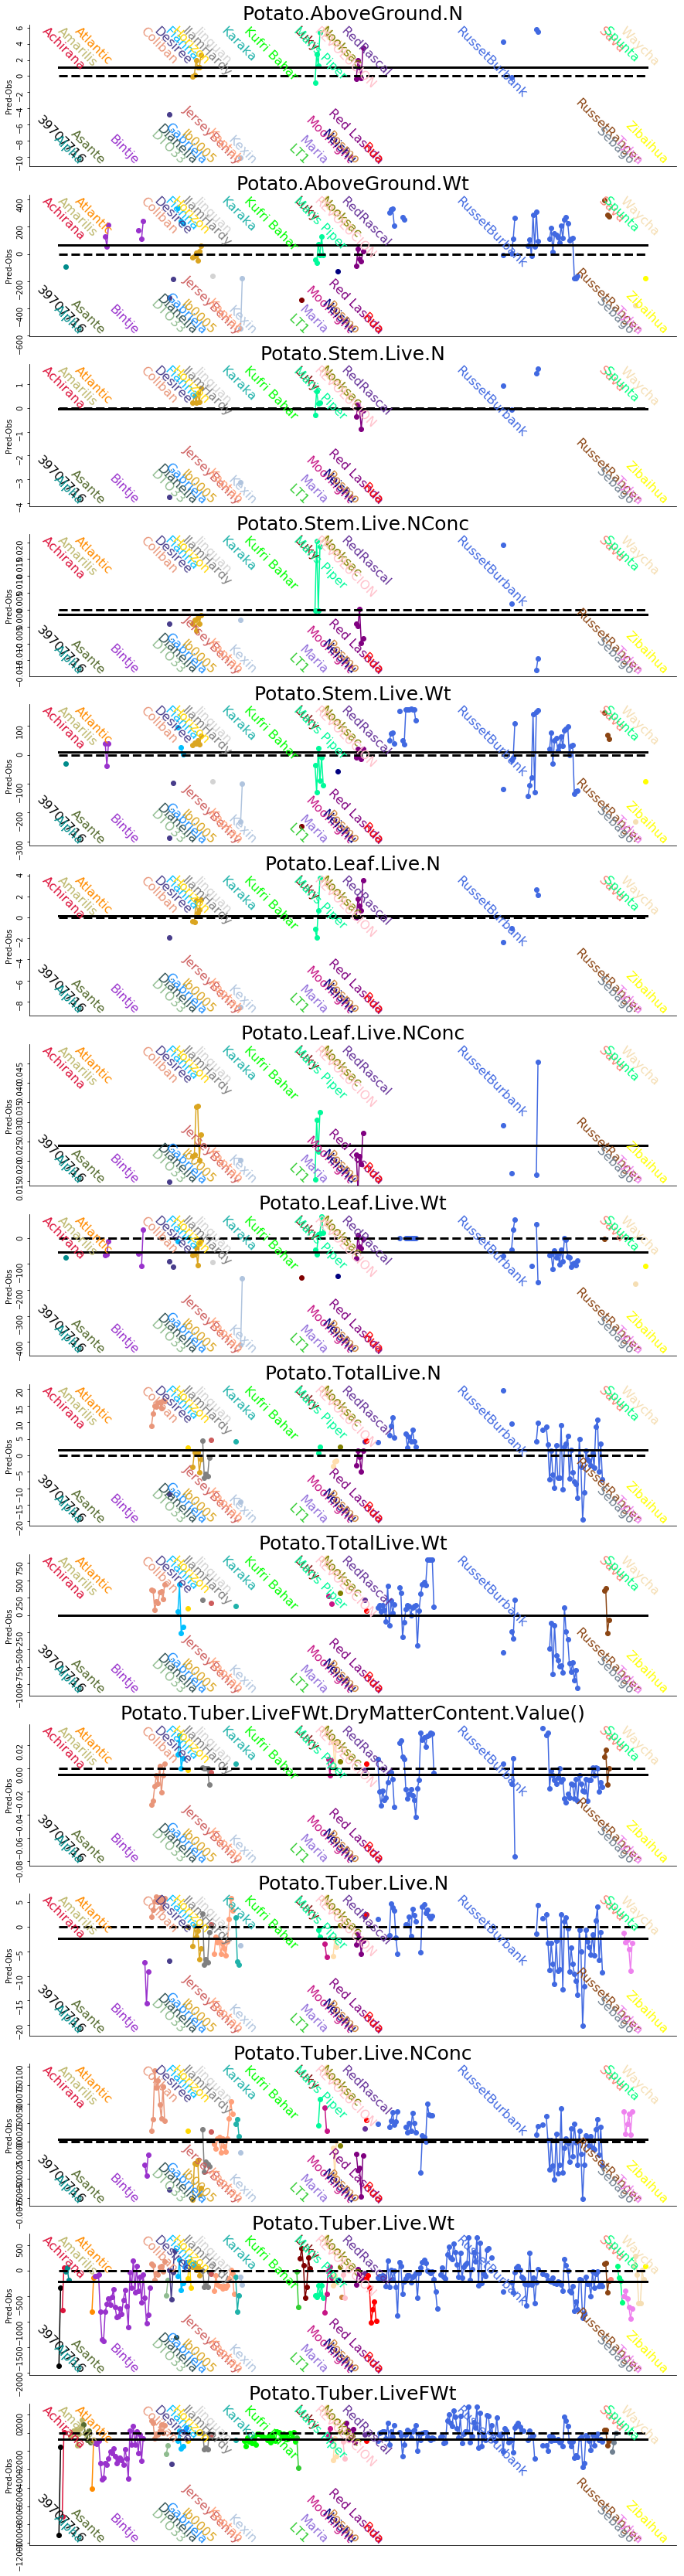

In [49]:
Graph = plt.figure(figsize=(15,60))
GroupResidulesGraph(PlotVariables,HarvestResiduals,Cultivars,'Cultivar')

## Graph residuals for key variables grouped by location

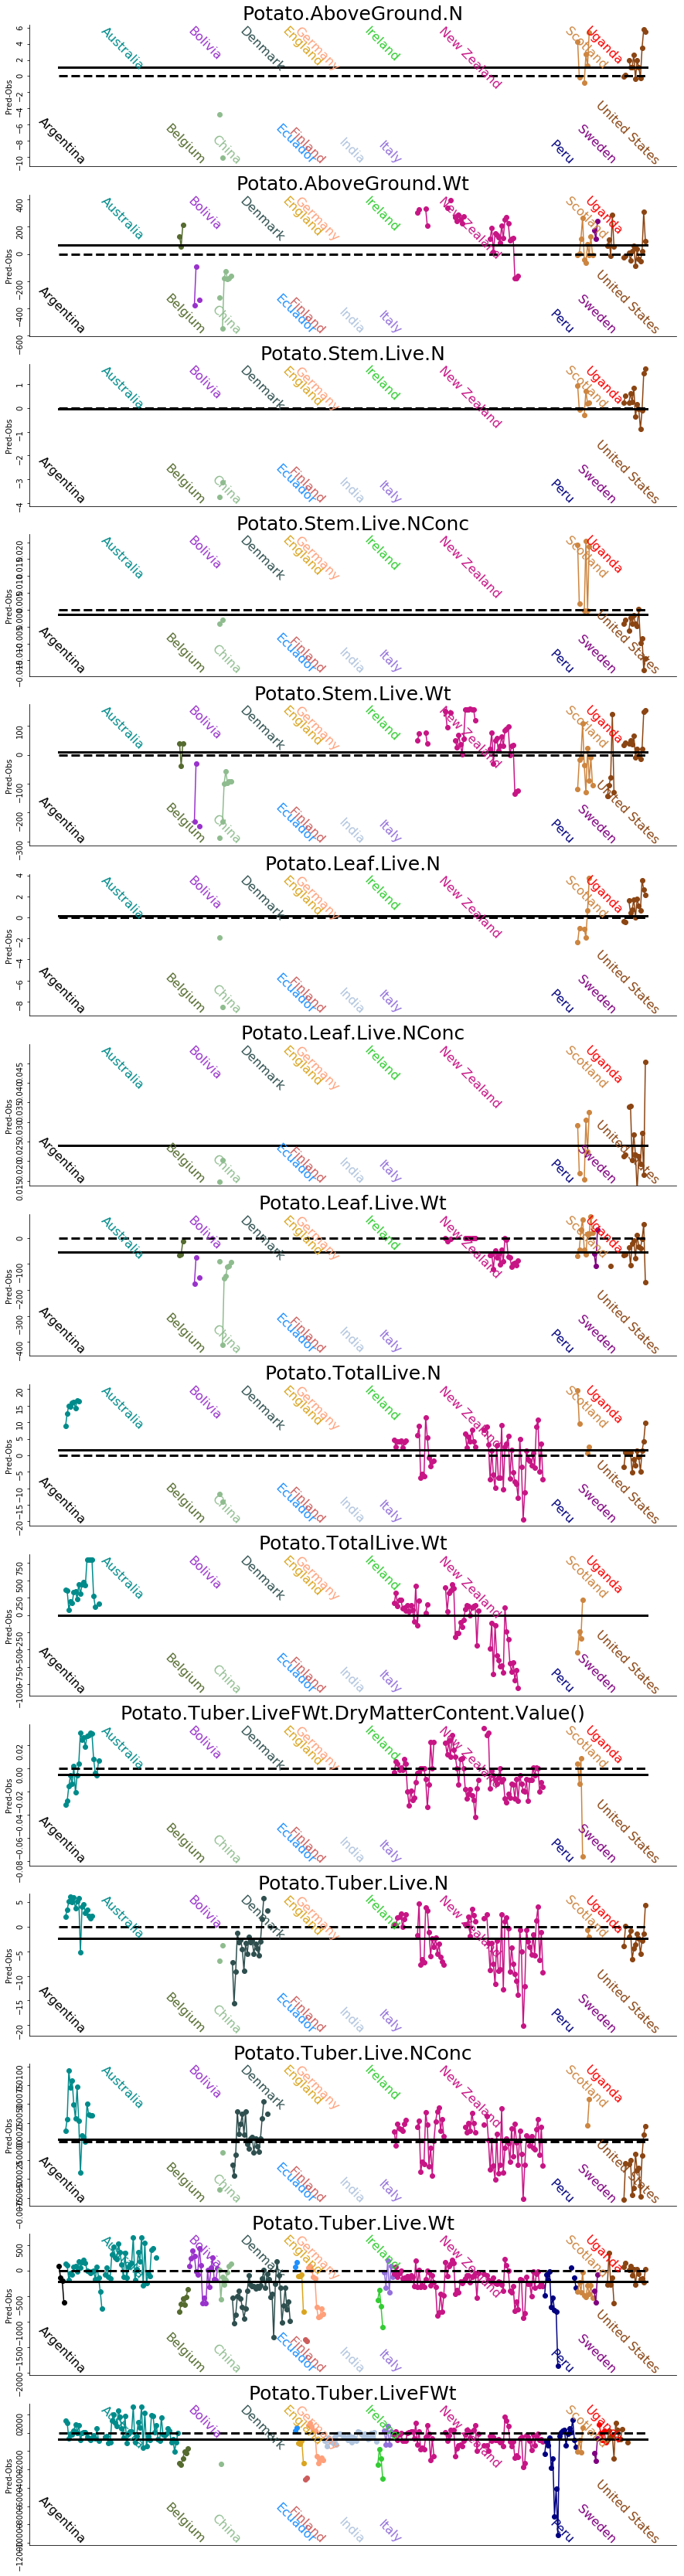

In [50]:
Graph = plt.figure(figsize=(15,60))
GroupResidulesGraph(PlotVariables,HarvestResiduals,Countries,'Country')

## Make graphs of residuals vs simulation configuration variables

In [51]:
def ResidulesVsVariable(ResidulesTable,Variable,GroupList,GroupVar,XVariables):
    pos = 1
    for vsVariable in XVariables:
        ax = Graph.add_subplot(4,2,pos)
        for group in GroupList:
            ColDF = globals()[GroupVar+'Props']
            col = ColDF.loc[group,'Color']
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupVar]==group,:].index.values
            yvals = ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.Potato.'+Variable]
            xvals = HarvestReport.reindex(SimIDs,axis=0).loc[:,vsVariable]
            plt.plot(xvals,yvals,'o',color=col,label=group)
            upper = HarvestReport.loc[:,vsVariable].max() * 1.1
            lower = HarvestReport.loc[:,vsVariable].min() * 0.8
            MeanResidual = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Variable].mean()
            plt.plot([lower,upper],[MeanResidual,MeanResidual],'-',lw=3,color='k')
            plt.plot([lower,upper],[0,0],'--',lw=3,color='k')
            plt.title('Pred-Obs ' + Variable + ' vs ' + vsVariable)
            plt.ylabel('Pred-Obs ' + Variable)
            plt.xlabel(vsVariable)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True)
        if pos == 1:
            GH.AddLegend(LegLoc = (0,1.1),labelsize=16,Title='',NCol=5,MScale=2)
        pos+=1

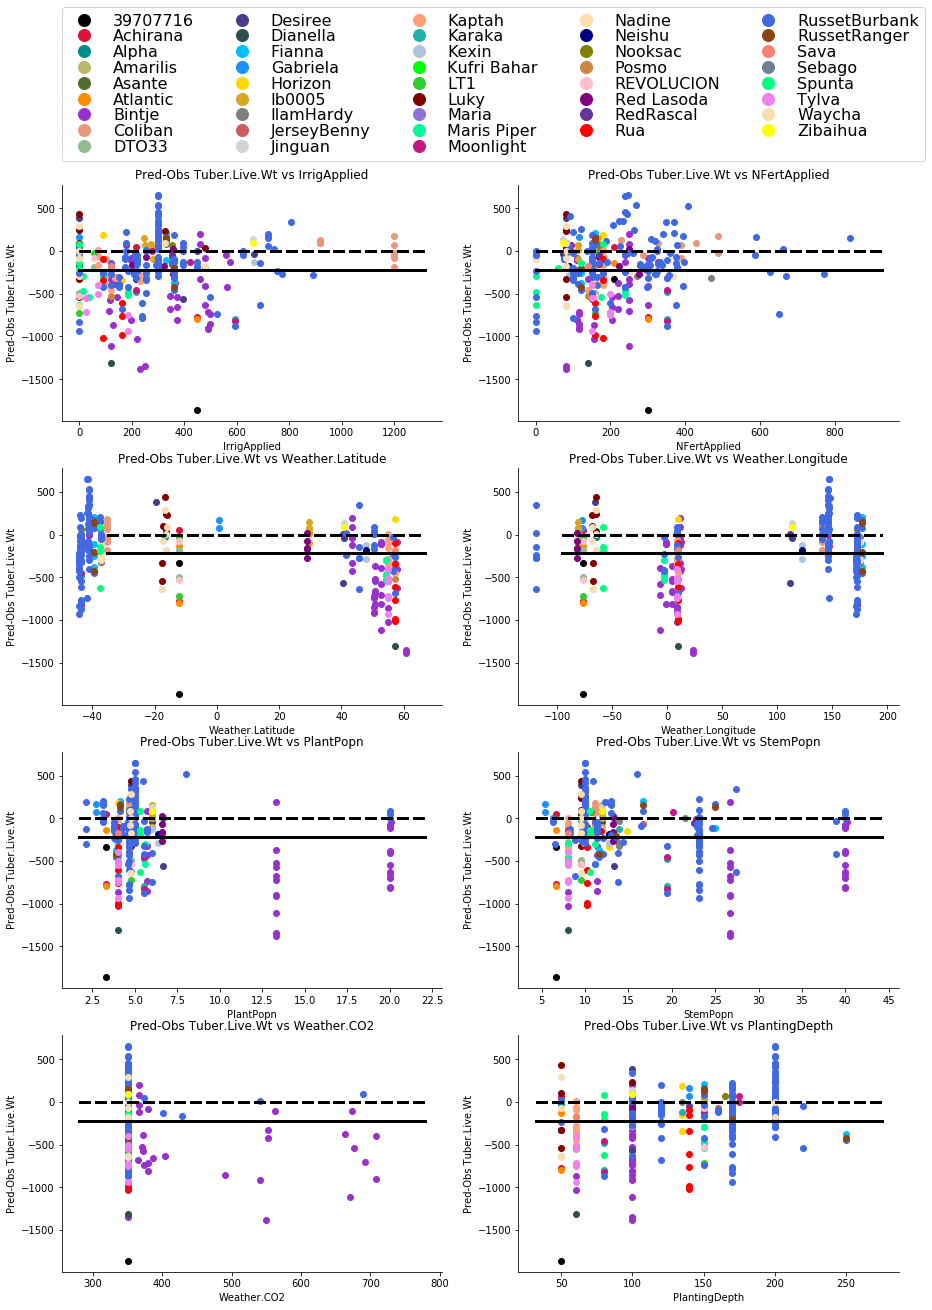

In [52]:
Graph = plt.figure(figsize=(15,20))
XVariables = ['IrrigApplied','NFertApplied','Weather.Latitude',
'Weather.Longitude','PlantPopn','StemPopn','Weather.CO2','PlantingDepth']
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Cultivars,'Cultivar',XVariables)

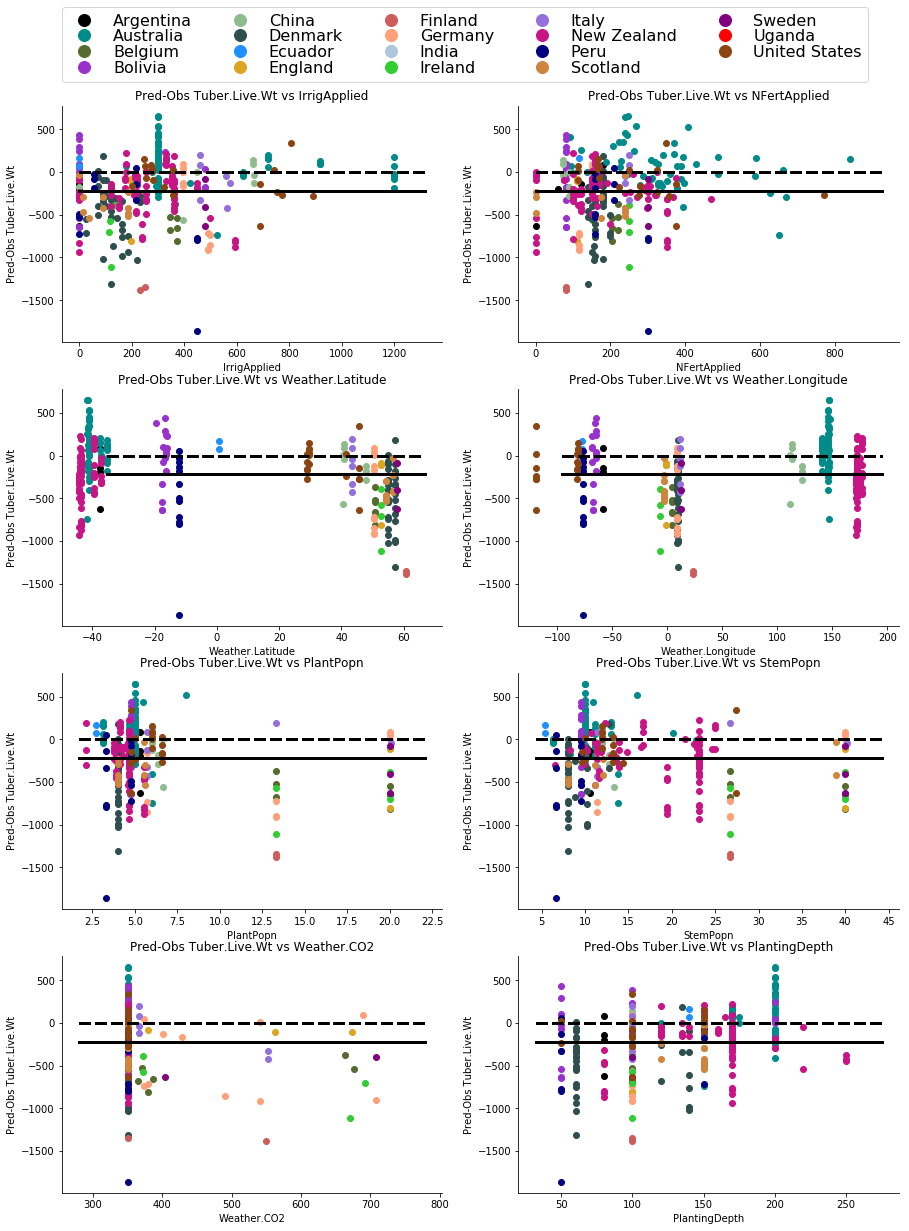

In [53]:
Graph = plt.figure(figsize=(15,20))
XVariables = ['IrrigApplied','NFertApplied','Weather.Latitude',
'Weather.Longitude','PlantPopn','StemPopn','Weather.CO2','PlantingDepth']
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Countries,'Country',XVariables)

In [54]:
def simsWithTimeCoarseData(Var):
    SimsWithTimeCoarseData = []
    for sim in DailyPreObs.index.drop_duplicates():
        try:
            obsNo = len(DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Var].dropna().values)
            if obsNo>1:
                SimsWithTimeCoarseData.append(sim)
        except:
            do = 'Nothing'
    return SimsWithTimeCoarseData

def ResidulesVsTtSow(Variable,GroupLabel,colourLabel):
    SimsWithTimeDataForVar = simsWithTimeCoarseData(Variable)
    WithTimeCoarseData = HarvestReport.reindex(SimsWithTimeDataForVar,axis=0).loc[:,GroupLabel].dropna().drop_duplicates().values
    Grouping = WithTimeCoarseData
    Grouping.sort()
    cols = np.ceil(len(Grouping)/5)
    pos=1
    upper = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].max() * 1.1
    lower = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].min() * 0.8
    MeanResidual = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].mean()
    DailyObsPredSims = DailyPreObs.index.drop_duplicates()
    for group in Grouping:
        ax = Graph.add_subplot(cols,5,pos)
        simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
        GroupSimsWithTimeCoarseData = list(set(HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index) & set(SimsWithTimeDataForVar))
        for sim in GroupSimsWithTimeCoarseData:
            col = ColProps.loc[sim,colourLabel]
            residuals = DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Variable]
            DatesWithObs = DailyReport.loc[:,'Clock.Today'].isin(DailyPreObs.loc[sim,'Clock.Today'])
            TtSow = DailyReport.loc[DatesWithObs,:].loc[sim,'Potato.Phenology.AccumulatedEmergedTT'].values
            try:
                plt.plot(TtSow,residuals,'o-',color=col,label=group)
            except:
                print(DailyReport.loc[sim,'SimulationName'].drop_duplicates())
        plt.text(0.03,1.0,group,transform=ax.transAxes,fontsize=12)
        plt.ylim(lower,upper)
        plt.plot([0,2300],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,2300],[0,0],'--',lw=3,color='k')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Pred-Obs '+Variable,fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Grouping)-4,len(Grouping)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel('TtAccumSow',fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos+=1
    plt.tight_layout

## Make Graphs of tuber live Wt residuals for each location plotted against thermal time since sowing

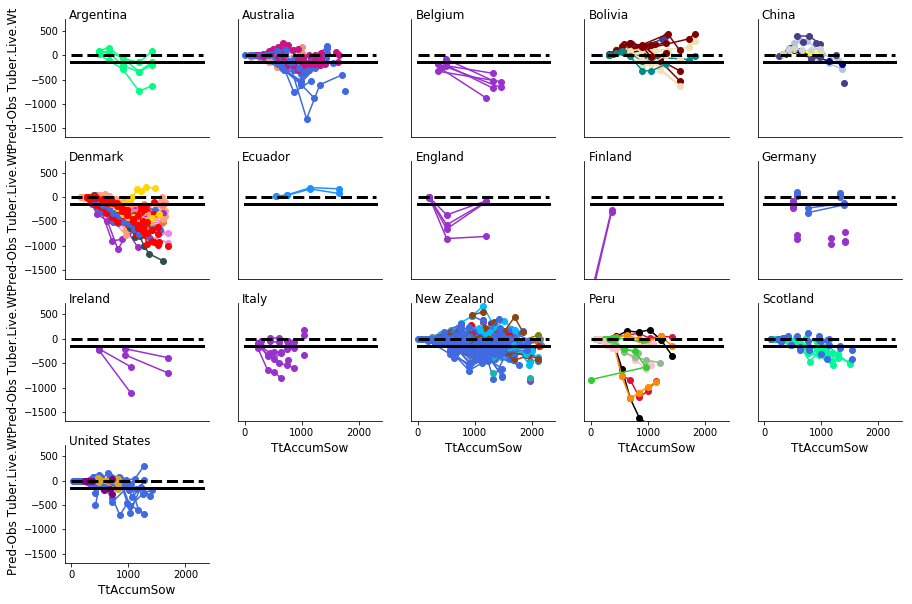

In [55]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Tuber.Live.Wt'
SortVar = 'Country'
ColorVar = 'Cultivar'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

## Make Graphs of tuber live Wt residuals for each Cultivar plotted against thermal time since sowing

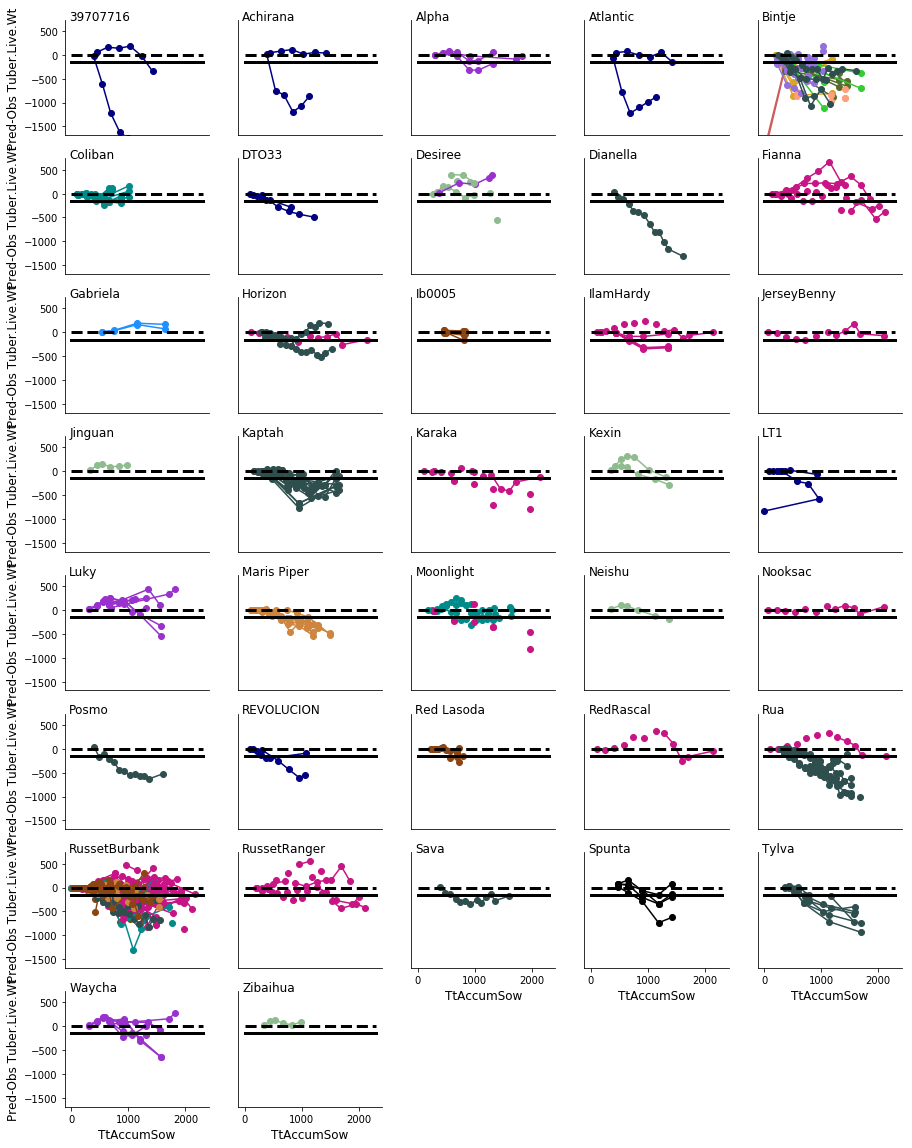

In [56]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Tuber.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

## Make Graphs of LAI residuals for each cultivar plotted against thermal time since sowing

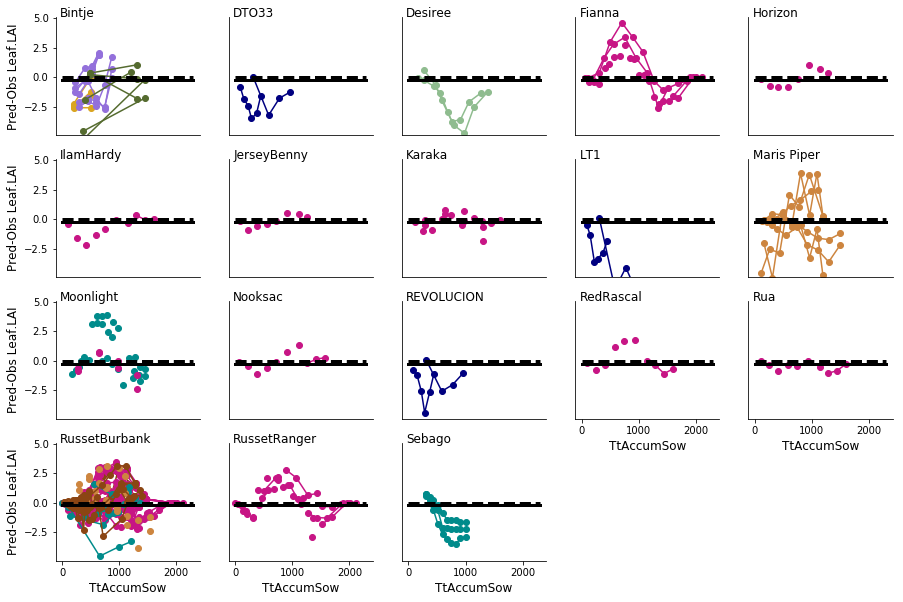

In [57]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Leaf.LAI'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

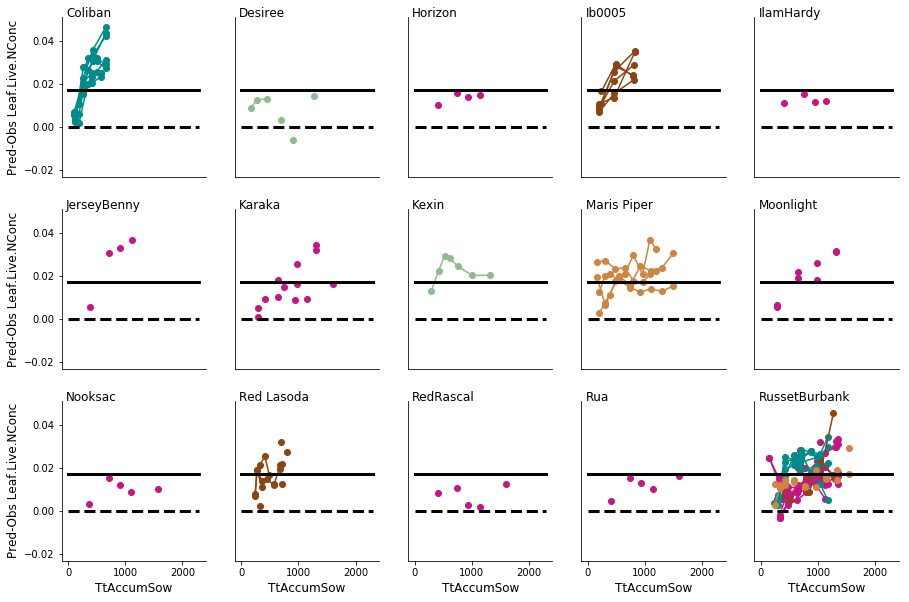

In [58]:
Graph = plt.figure(figsize=(15,10))
PlotVar = 'Leaf.Live.NConc'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

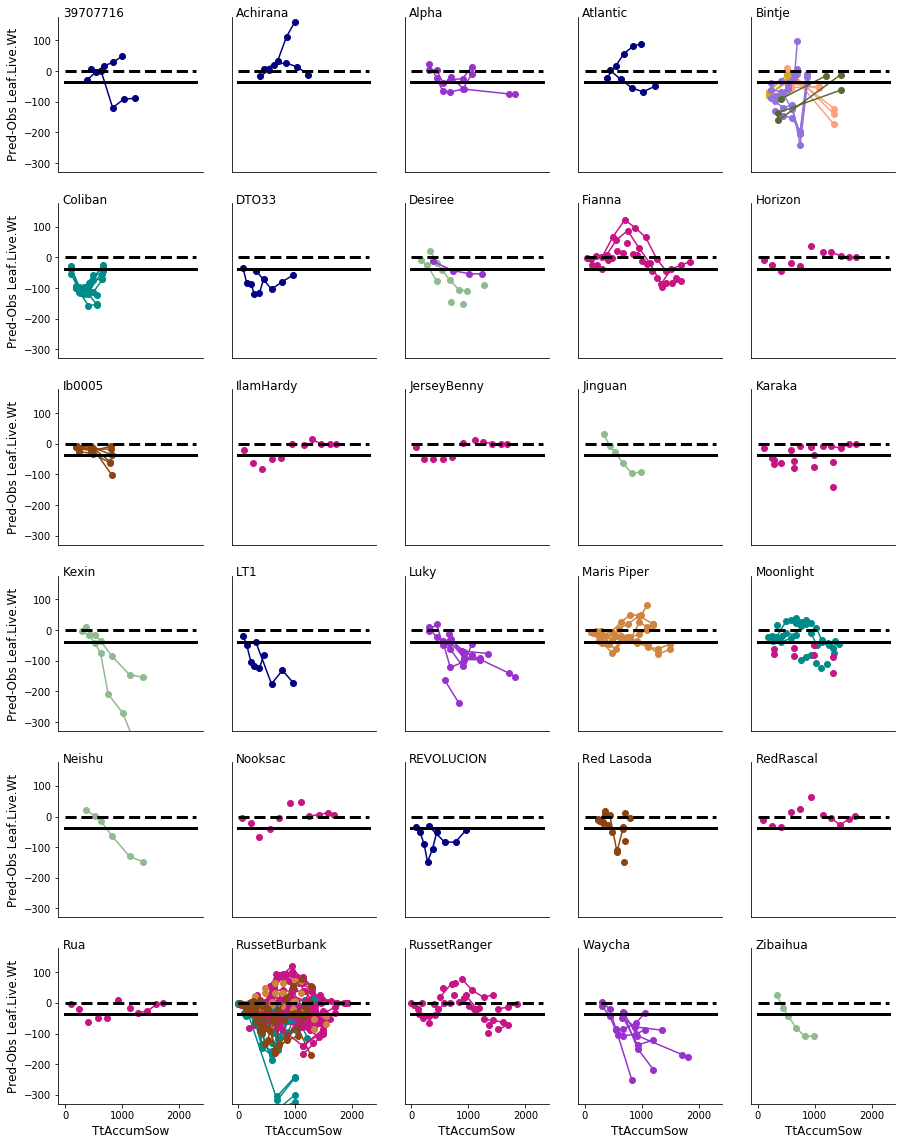

In [59]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Leaf.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

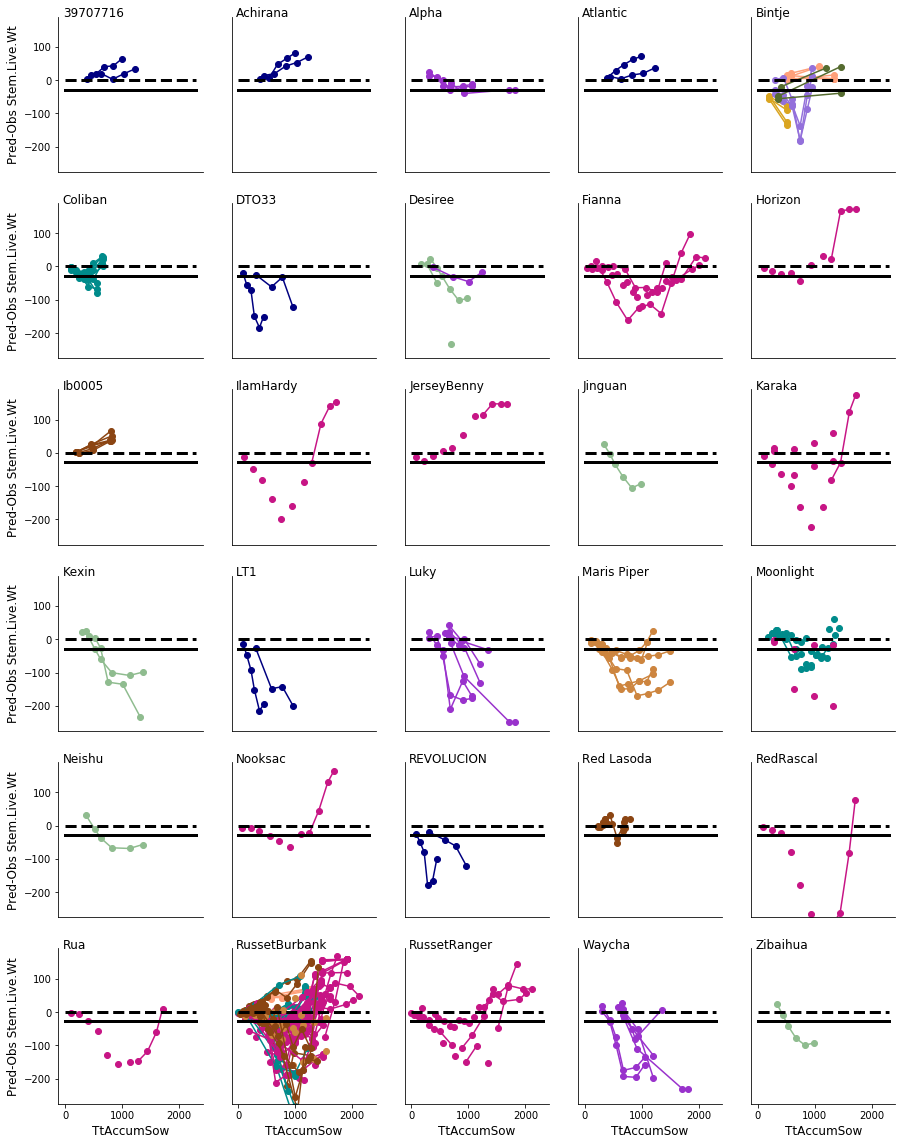

In [60]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Stem.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

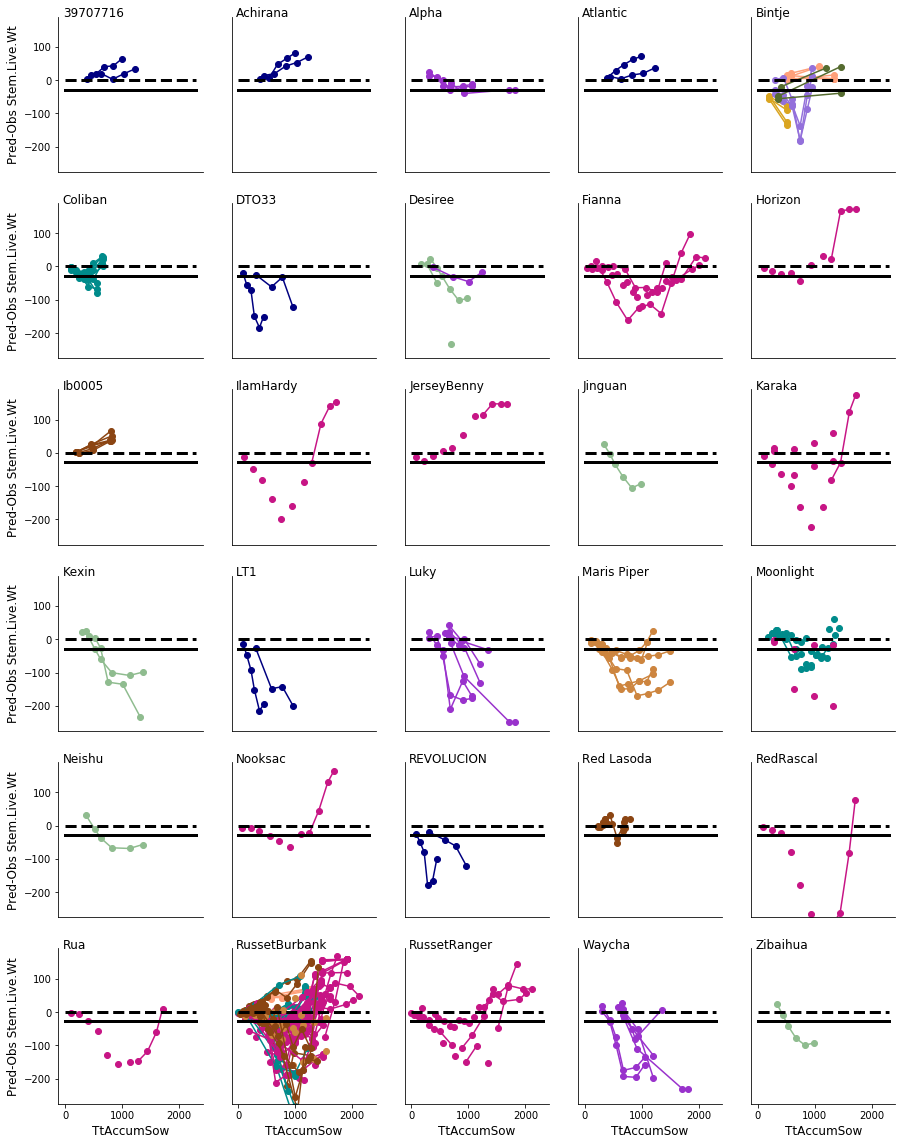

In [61]:
Graph = plt.figure(figsize=(15,20))
PlotVar = 'Stem.Live.Wt'
SortVar = 'Cultivar'
ColorVar = 'Country'
ResidulesVsTtSow(PlotVar,SortVar,ColorVar)

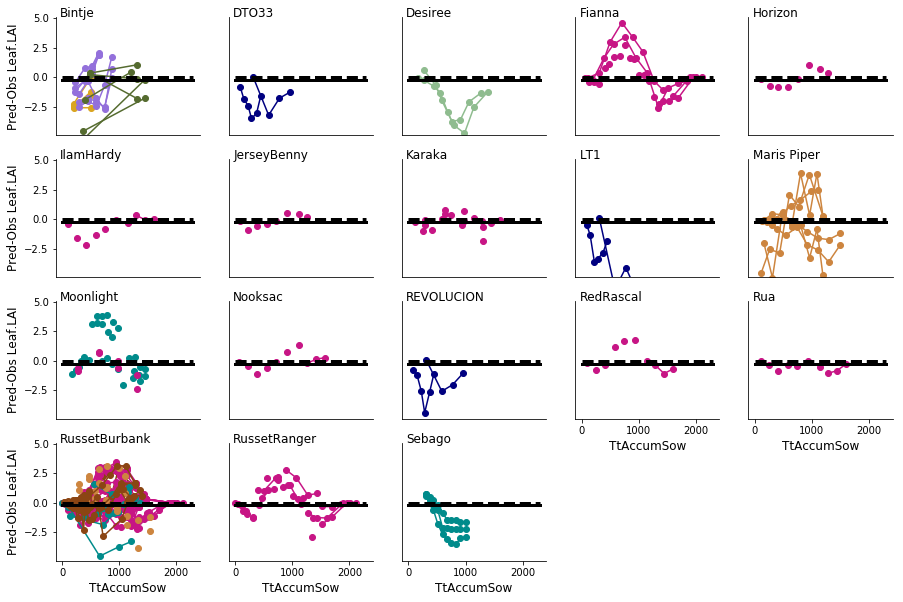

In [62]:
Graph = plt.figure(figsize=(15,10))
ResidulesVsTtSow('Leaf.LAI','Cultivar','Country')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text xticklabel objects>)

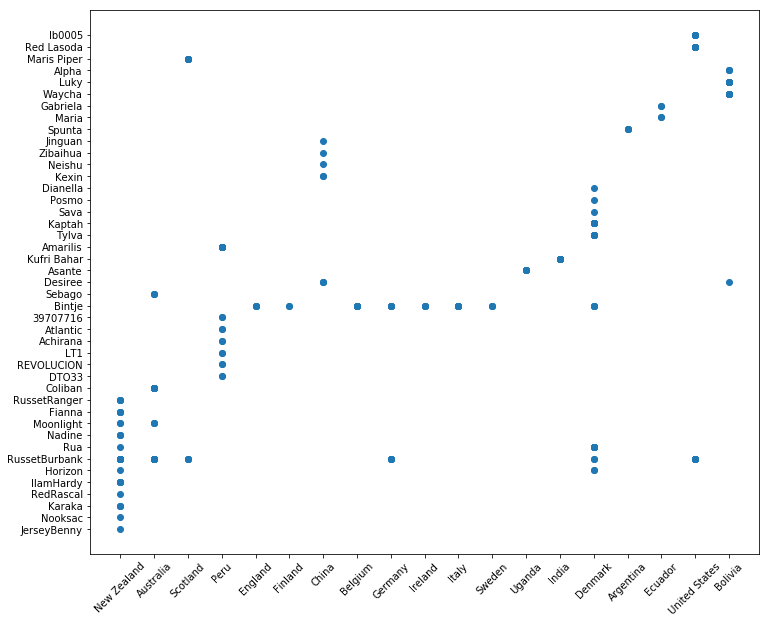

In [72]:
Graph = plt.figure(figsize=(12,10))
plt.plot(HarvestReport.Country,HarvestReport.Cultivar,'o')
plt.xticks(rotation=45)

In [76]:
CultByCountry = HarvestReport.reindex(['Country','Cultivar'],axis=1).drop_duplicates()

In [81]:
HarvestReport.loc[:,'Country']

SimulationID
5      New Zealand
4      New Zealand
7      New Zealand
3      New Zealand
6      New Zealand
2      New Zealand
1      New Zealand
8      New Zealand
11     New Zealand
9      New Zealand
10     New Zealand
14     New Zealand
12     New Zealand
15     New Zealand
13     New Zealand
16     New Zealand
20     New Zealand
18     New Zealand
21     New Zealand
17     New Zealand
19     New Zealand
22     New Zealand
23     New Zealand
24     New Zealand
25     New Zealand
26     New Zealand
27     New Zealand
28     New Zealand
29     New Zealand
30     New Zealand
          ...     
333    New Zealand
334    New Zealand
336    New Zealand
335    New Zealand
338    New Zealand
337    New Zealand
339    New Zealand
341    New Zealand
340    New Zealand
342    New Zealand
343    New Zealand
345    New Zealand
344    New Zealand
346    New Zealand
347    New Zealand
349    New Zealand
348    New Zealand
352    New Zealand
351    New Zealand
350    New Zealand
353    New Zealand

In [82]:
for CbC in CultByCountry.index.size:
    CultCountryFilter = (HarvestReport.loc[:,'Country'] == CbC[0]) & \
                        (HarvestReport.loc[:,'Cultivar'] == CbC[1])
    CultByCountry.loc[CbC,'Count'] = HarvestReport.loc[CultCountryFilter,:].index.size

In [87]:
CultByCountry

Country       Cultivar  Count
SimulationID                                     
5               New Zealand    JerseyBenny    NaN
4               New Zealand        Nooksac    NaN
7               New Zealand         Karaka    NaN
3               New Zealand      RedRascal    NaN
6               New Zealand      IlamHardy    NaN
2               New Zealand        Horizon    NaN
1               New Zealand  RussetBurbank    NaN
8               New Zealand            Rua    NaN
23              New Zealand         Nadine    NaN
28              New Zealand      Moonlight    NaN
33              New Zealand         Fianna    NaN
34              New Zealand   RussetRanger    NaN
53                Australia        Coliban    NaN
62                Australia  RussetBurbank    NaN
70                Australia      Moonlight    NaN
119                Scotland  RussetBurbank    NaN
125                    Peru          DTO33    NaN
126                    Peru     REVOLUCION    NaN
124                    Peru            LT1    NaN
129                    Peru       Achirana    NaN
131                    Peru       Atlantic    NaN
130                    Peru       39707716    NaN
135                 England         Bintje    NaN
142                 Finland         Bintje    NaN
147               Australia         Sebago    NaN
146                   China        Desiree    NaN
149                 Belgium         Bintje    NaN
155                 Germany  RussetBurbank    NaN
160                 Germany         Bintje    NaN
167                 Ireland         Bintje    NaN
...                     ...            ...    ...
175                  Sweden         Bintje    NaN
178                  Uganda         Asante    NaN
184                   India    Kufri Bahar    NaN
191                    Peru       Amarilis    NaN
202                 Denmark         Bintje    NaN
206                 Denmark          Tylva    NaN
211                 Denmark         Kaptah    NaN
224                 Denmark           Sava    NaN
225                 Denmark          Posmo    NaN
227                 Denmark       Dianella    NaN
228                 Denmark  RussetBurbank    NaN
229                 Denmark        Horizon    NaN
230                 Denmark            Rua    NaN
237                   China          Kexin    NaN
240                   China         Neishu    NaN
241                   China       Zibaihua    NaN
243                   China        Jinguan    NaN
244               Argentina         Spunta    NaN
248                 Ecuador          Maria    NaN
249                 Ecuador       Gabriela    NaN
253           United States  RussetBurbank    NaN
257                 Bolivia         Waycha    NaN
258                 Bolivia           Luky    NaN
259                 Bolivia        Desiree    NaN
261                 Bolivia          Alpha    NaN
300                Scotland    Maris Piper    NaN
306           United States     Red Lasoda    NaN
311           United States         Ib0005    NaN
Country                 NaN            NaN    0.0
Cultivar                NaN            NaN    0.0

[61 rows x 3 columns]

In [94]:
HarvestReport.loc[CultCountryFilter,:].index.size

1

In [95]:
CbC = CultByCountry.iloc[0]
CultCountryFilter = (HarvestReport.loc[:,'Country'] == CbC[0]) & \
                    (HarvestReport.loc[:,'Cultivar'] == CbC[1])
CultByCountry.loc[(CbC[0],CbC[1]),'Count'] = HarvestReport.loc[CultCountryFilter,:].index.size

KeyError: "['New Zealand' 'JerseyBenny'] not in index"

In [83]:
CultByCountry

Country       Cultivar  Count
SimulationID                                     
5               New Zealand    JerseyBenny    NaN
4               New Zealand        Nooksac    NaN
7               New Zealand         Karaka    NaN
3               New Zealand      RedRascal    NaN
6               New Zealand      IlamHardy    NaN
2               New Zealand        Horizon    NaN
1               New Zealand  RussetBurbank    NaN
8               New Zealand            Rua    NaN
23              New Zealand         Nadine    NaN
28              New Zealand      Moonlight    NaN
33              New Zealand         Fianna    NaN
34              New Zealand   RussetRanger    NaN
53                Australia        Coliban    NaN
62                Australia  RussetBurbank    NaN
70                Australia      Moonlight    NaN
119                Scotland  RussetBurbank    NaN
125                    Peru          DTO33    NaN
126                    Peru     REVOLUCION    NaN
124                    Peru            LT1    NaN
129                    Peru       Achirana    NaN
131                    Peru       Atlantic    NaN
130                    Peru       39707716    NaN
135                 England         Bintje    NaN
142                 Finland         Bintje    NaN
147               Australia         Sebago    NaN
146                   China        Desiree    NaN
149                 Belgium         Bintje    NaN
155                 Germany  RussetBurbank    NaN
160                 Germany         Bintje    NaN
167                 Ireland         Bintje    NaN
...                     ...            ...    ...
175                  Sweden         Bintje    NaN
178                  Uganda         Asante    NaN
184                   India    Kufri Bahar    NaN
191                    Peru       Amarilis    NaN
202                 Denmark         Bintje    NaN
206                 Denmark          Tylva    NaN
211                 Denmark         Kaptah    NaN
224                 Denmark           Sava    NaN
225                 Denmark          Posmo    NaN
227                 Denmark       Dianella    NaN
228                 Denmark  RussetBurbank    NaN
229                 Denmark        Horizon    NaN
230                 Denmark            Rua    NaN
237                   China          Kexin    NaN
240                   China         Neishu    NaN
241                   China       Zibaihua    NaN
243                   China        Jinguan    NaN
244               Argentina         Spunta    NaN
248                 Ecuador          Maria    NaN
249                 Ecuador       Gabriela    NaN
253           United States  RussetBurbank    NaN
257                 Bolivia         Waycha    NaN
258                 Bolivia           Luky    NaN
259                 Bolivia        Desiree    NaN
261                 Bolivia          Alpha    NaN
300                Scotland    Maris Piper    NaN
306           United States     Red Lasoda    NaN
311           United States         Ib0005    NaN
Country                 NaN            NaN    0.0
Cultivar                NaN            NaN    0.0

[61 rows x 3 columns]